In [1]:
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

print(tf.__version__)

2.0.0-rc1


In [2]:
#Import from file
data = pd.read_csv("data.txt", names=['time', 'value', 'zero'])
#Drop null column
data.drop('zero', axis=1, inplace=True)
#Make time-column start from zero
data['time'] = data['time'].apply(lambda x : x - data['time'][0])
#Print first 5 rows
data.head(5)
#print(data.shape)

time     value
0     0  0.866805
1     1  0.848815
2     2  0.843006
3     3  0.831201
4     4  0.820492

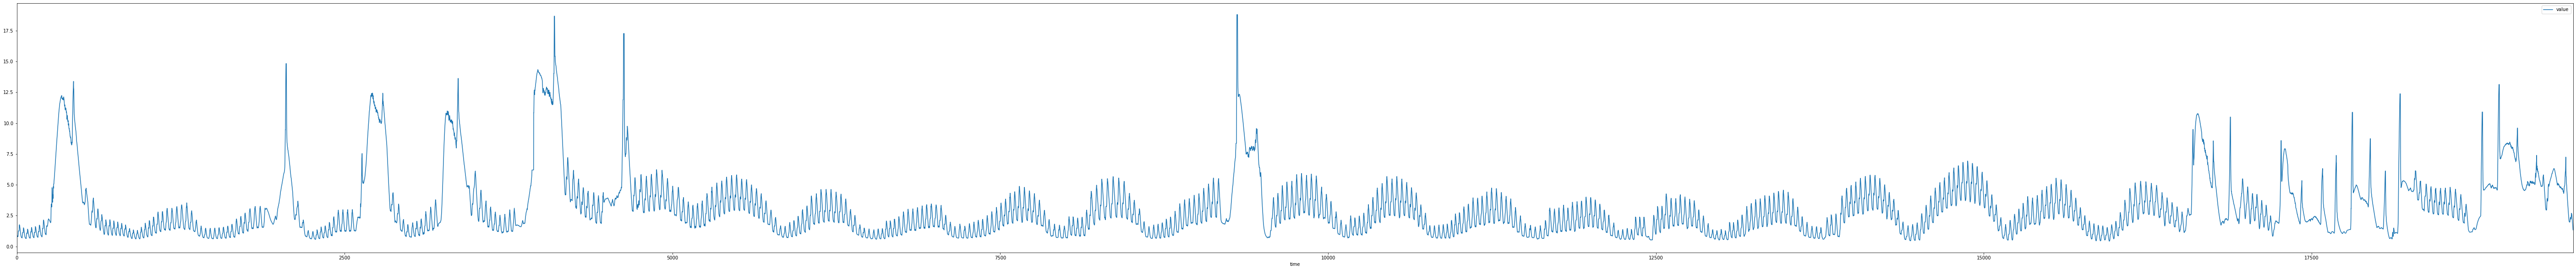

In [23]:
data.plot(x ='time', y='value', kind='line', figsize=(100,10))

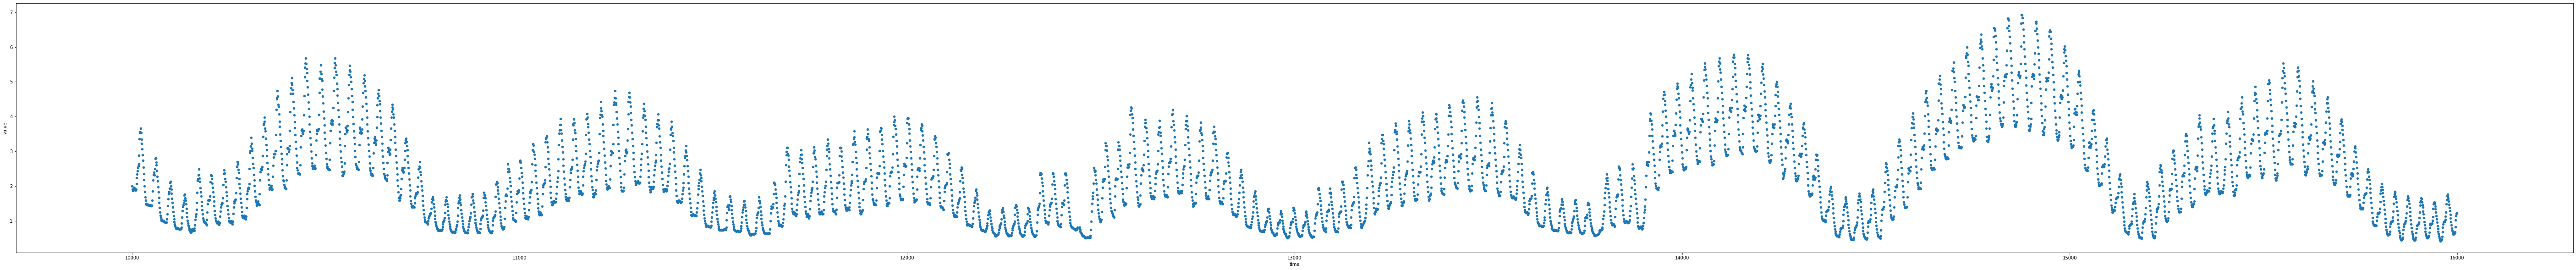

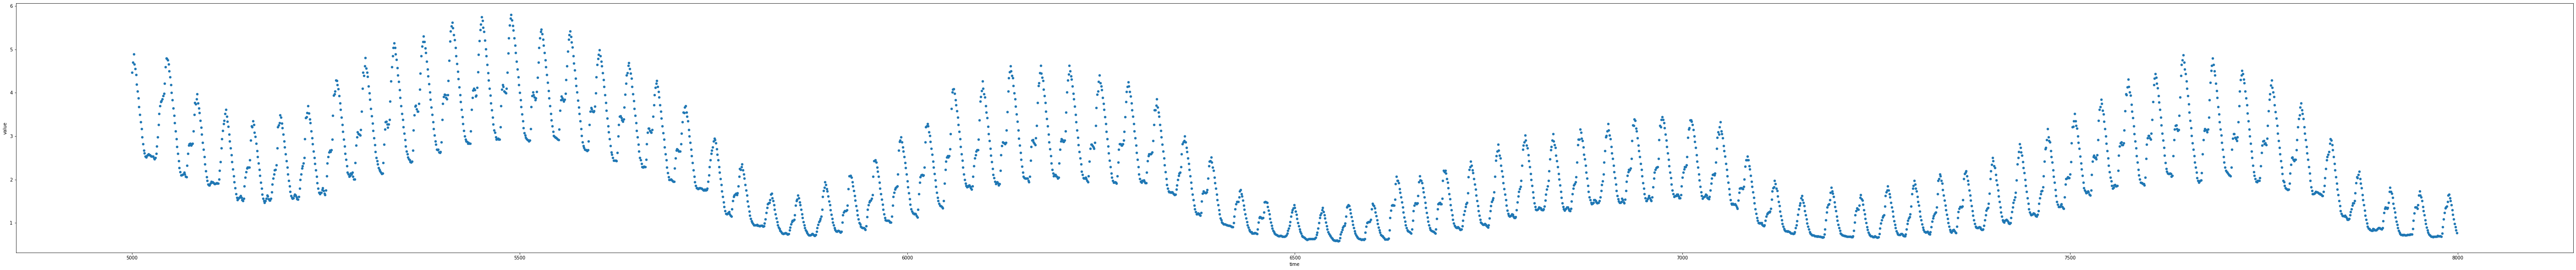

In [4]:
train = data.iloc[10000:16000]
test = data.iloc[5000:8000]
train.plot(x ='time', y='value', kind='scatter', figsize=(100,10))
test.plot(x ='time', y='value', kind='scatter', figsize=(100,10))

In [5]:
#Convert dataframe to nparray
train_data = train.to_numpy()#train.values
print(train_data.shape)
#Train on 5000, test on 1000
TRAIN_SPLIT=5000

#Normalize
#train_mean = train_data[:TRAIN_SPLIT].mean()
#train_std = train_data[:TRAIN_SPLIT].std()
#train_data = (train_data-train_mean)/train_std

#train_data = (train_data-train_data.min())/(train_data.max()-train_data.min())

print(train_data.shape)

(6000, 2)
(6000, 2)


In [6]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
    dataset = dataset[:, [1]]
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i)
        # Reshape data from (history_size,) to (history_size, 1)
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        labels.append(dataset[i+target_size])
    return np.array(data), np.array(labels)

In [7]:
#Preduict next, using past 80
past_history = 80
future_target = 0

x_train_uni, y_train_uni = univariate_data(train_data, 0, TRAIN_SPLIT, past_history, future_target)
x_val_uni, y_val_uni = univariate_data(train_data, TRAIN_SPLIT, None, past_history, future_target)

In [8]:
print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target value to predict')
print (y_train_uni[0])

Single window of past history
[[1.99721]
 [1.90745]
 [1.87128]
 [1.90212]
 [1.92605]
 [1.95673]
 [1.95334]
 [1.90003]
 [1.88247]
 [1.88271]
 [1.90592]
 [2.06542]
 [2.23563]
 [2.34521]
 [2.44206]
 [2.52678]
 [2.57962]
 [2.63054]
 [2.88719]
 [3.35474]
 [3.56335]
 [3.53156]
 [3.65846]
 [3.53941]
 [3.34378]
 [3.2302 ]
 [3.0709 ]
 [2.89177]
 [2.73476]
 [2.53734]
 [2.35306]
 [2.18661]
 [2.00556]
 [1.8446 ]
 [1.68487]
 [1.58773]
 [1.50296]
 [1.47324]
 [1.45813]
 [1.46195]
 [1.46387]
 [1.4724 ]
 [1.46573]
 [1.45307]
 [1.45235]
 [1.45896]
 [1.46036]
 [1.45918]
 [1.45147]
 [1.4349 ]
 [1.43234]
 [1.44849]
 [1.58862]
 [1.86165]
 [2.1675 ]
 [2.33507]
 [2.39341]
 [2.33528]
 [2.32147]
 [2.50014]
 [2.79429]
 [2.8107 ]
 [2.68483]
 [2.61024]
 [2.4517 ]
 [2.28402]
 [2.14212]
 [1.9791 ]
 [1.83247]
 [1.67561]
 [1.52754]
 [1.3824 ]
 [1.25397]
 [1.15339]
 [1.10172]
 [1.05951]
 [1.01799]
 [1.00161]
 [1.00679]
 [1.01464]]

 Target value to predict
[1.00616]


In [9]:
def create_time_steps(length):
    time_steps = []
    for i in range(-length, 0, 1):
        time_steps.append(i)
    return time_steps

def show_plot(plot_data, delta, title):
    labels = ['History', 'Ground truth', 'Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
          plt.plot(future, plot_data[i], marker[i], markersize=10,
                   label=labels[i])
        else:
          plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Time-Step')
    return plt

In [10]:
BATCH_SIZE = 128
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [21]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    #tf.keras.layers.Dense(16, activation='relu'),
    #tf.keras.layers.LSTM(16, activation='relu', return_sequences=True),
    #tf.keras.layers.Dropout(0.1),
    #tf.keras.layers.LSTM(8, activation='relu'),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

In [19]:
EVALUATION_INTERVAL = 200
EPOCHS = 30

simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/30
200/200 [==============================] - 9s 44ms/step - loss: 0.7636 - val_loss: 0.2862
Epoch 2/30
200/200 [==============================] - 6s 31ms/step - loss: 0.2620 - val_loss: 0.1778
Epoch 3/30
200/200 [==============================] - 6s 32ms/step - loss: 0.1730 - val_loss: 0.1264
Epoch 4/30
200/200 [==============================] - 6s 32ms/step - loss: 0.1323 - val_loss: 0.1055
Epoch 5/30
200/200 [==============================] - 7s 33ms/step - loss: 0.1187 - val_loss: 0.0910
Epoch 6/30
200/200 [==============================] - 7s 33ms/step - loss: 0.1117 - val_loss: 0.1110
Epoch 7/30
200/200 [==============================] - 7s 33ms/step - loss: 0.1056 - val_loss: 0.0968
Epoch 8/30
200/200 [==============================] - 6s 32ms/step - loss: 0.1000 - val_loss: 0.0796
Epoch 9/30
200/200 [==============================] - 6s 32ms/step - loss: 0.0972 - val_loss: 0.0849
Epoch 10/30
200/200 [===========================

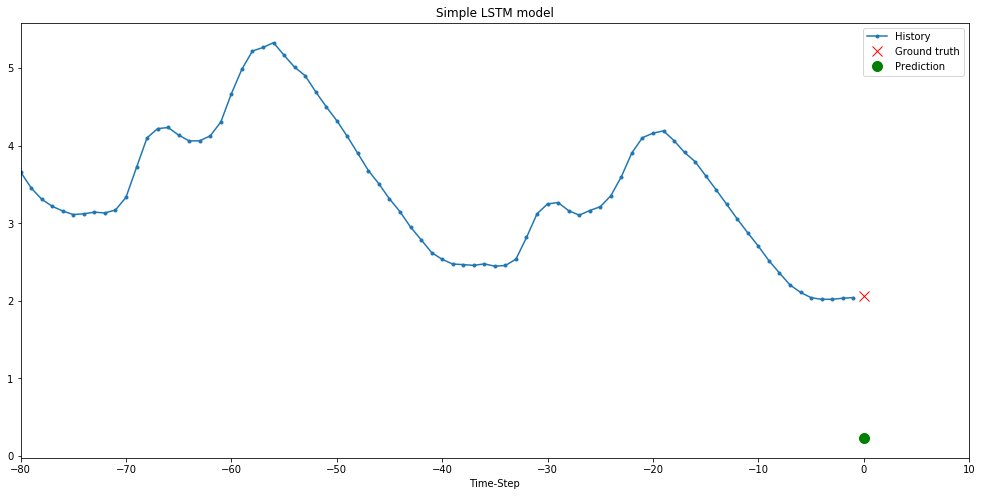

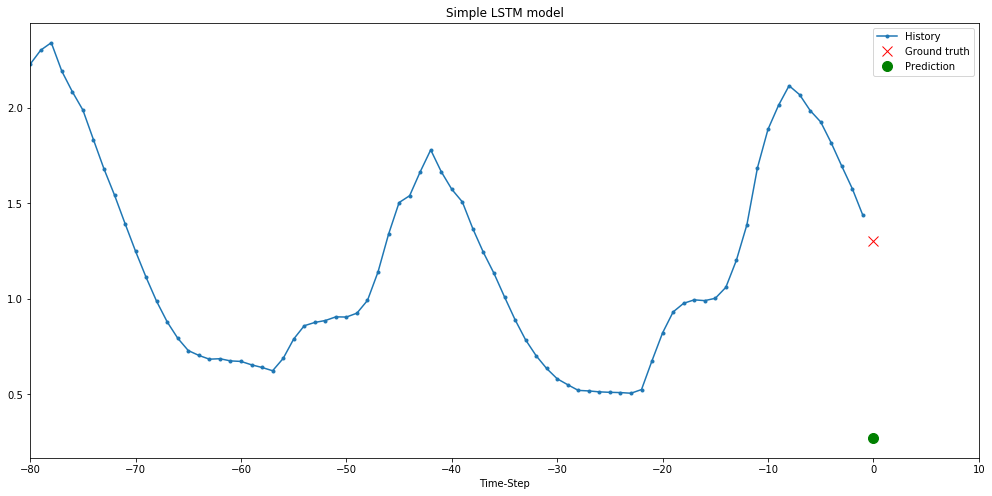

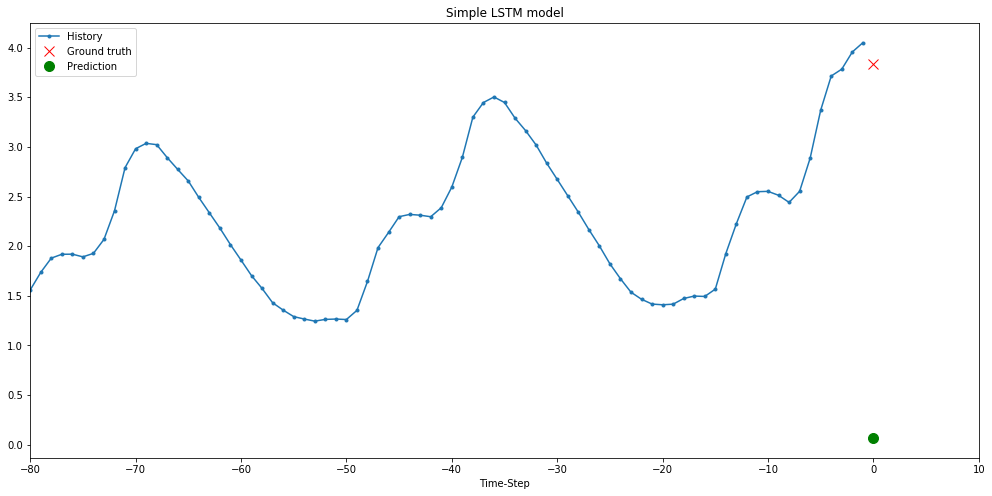

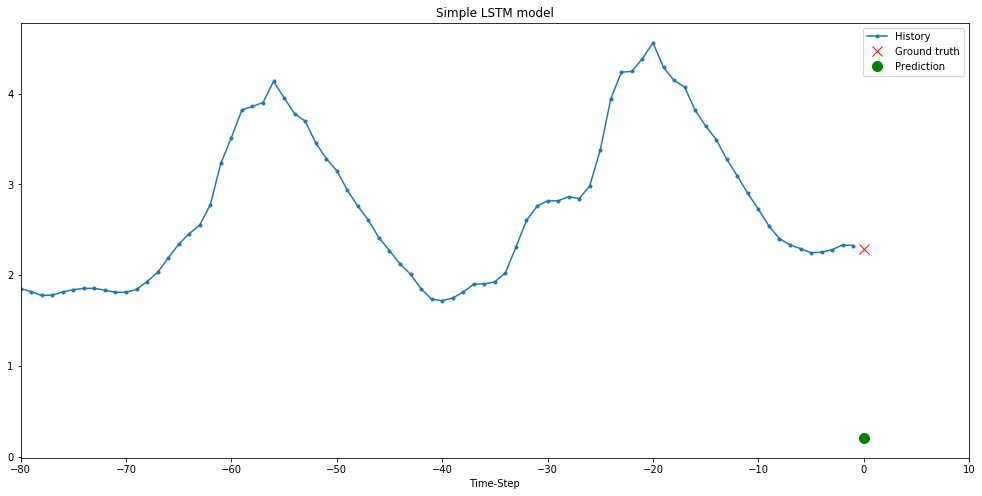

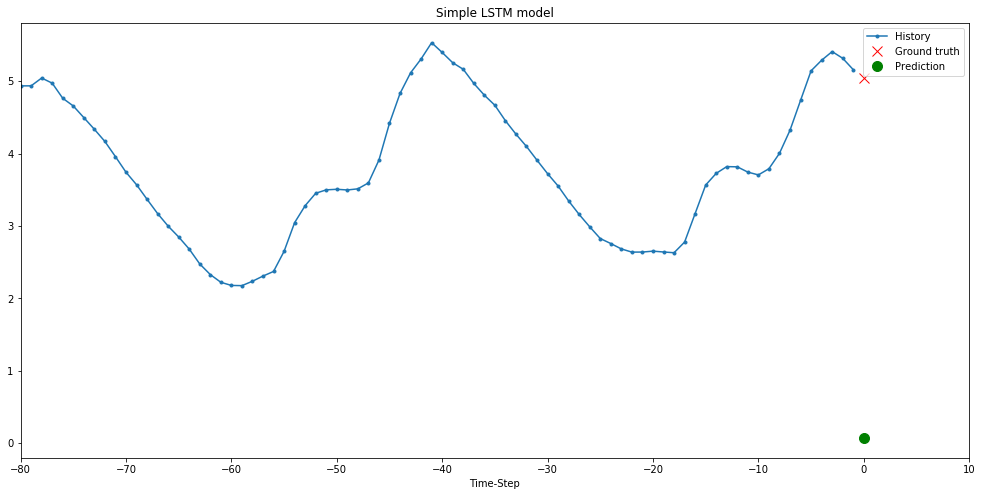

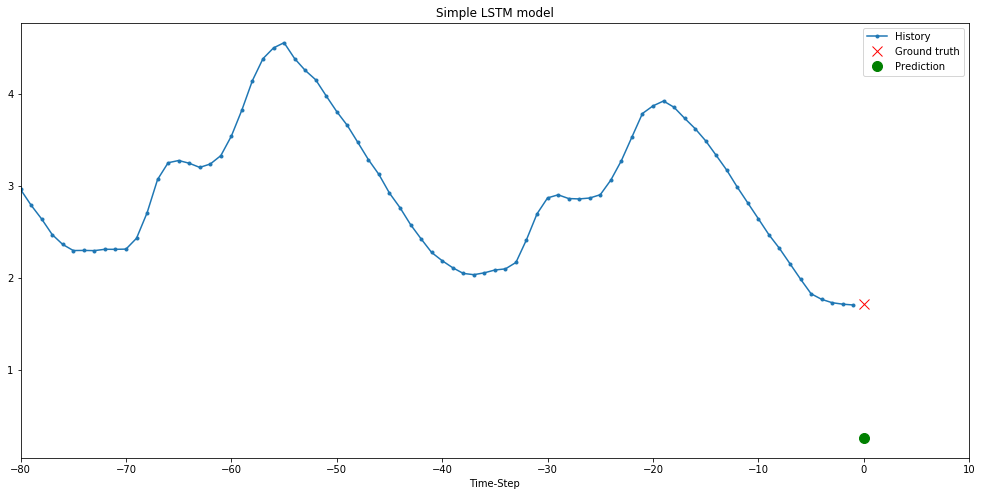

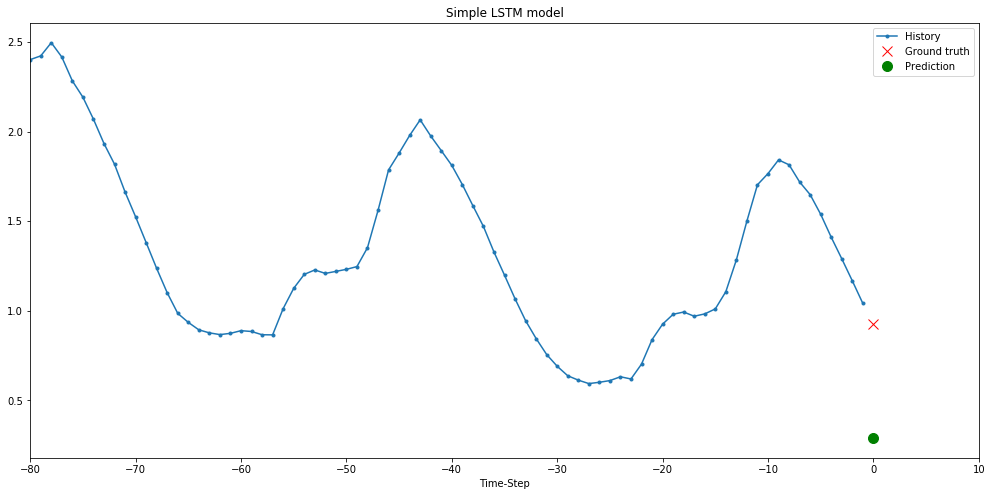

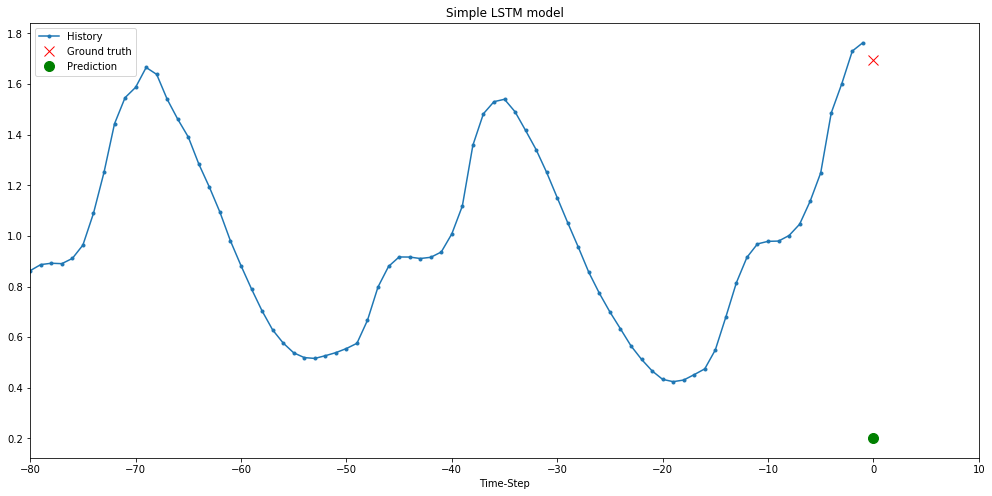

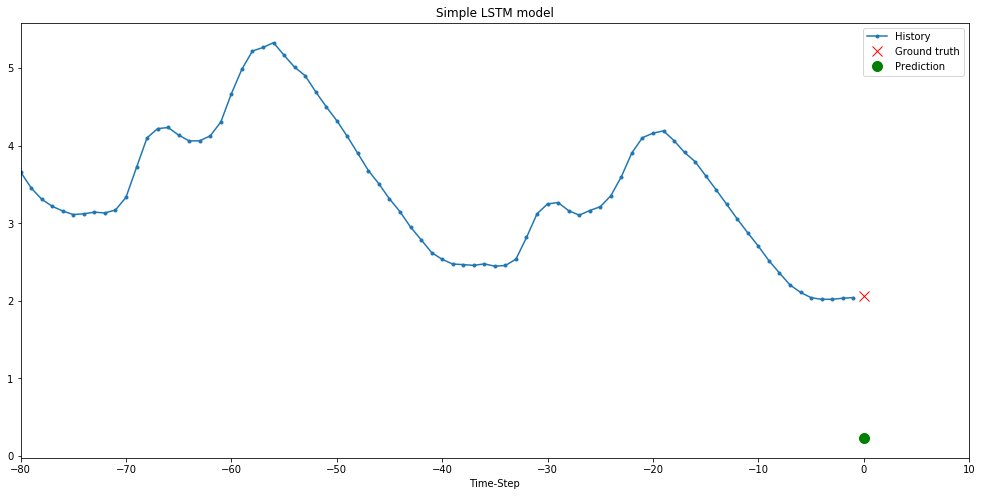

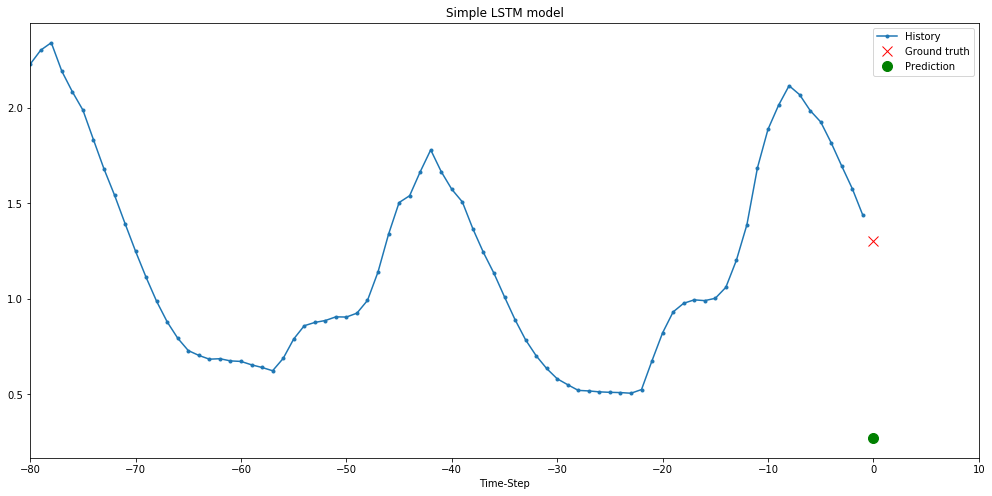

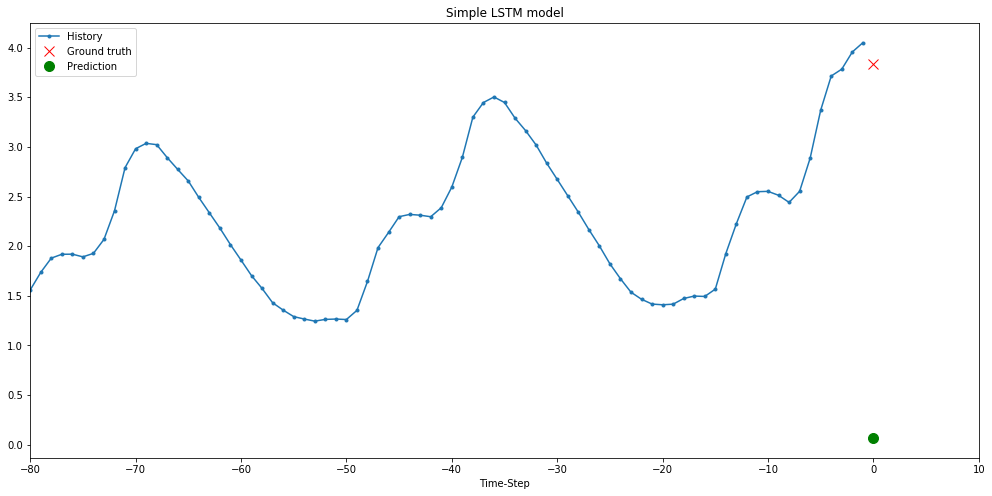

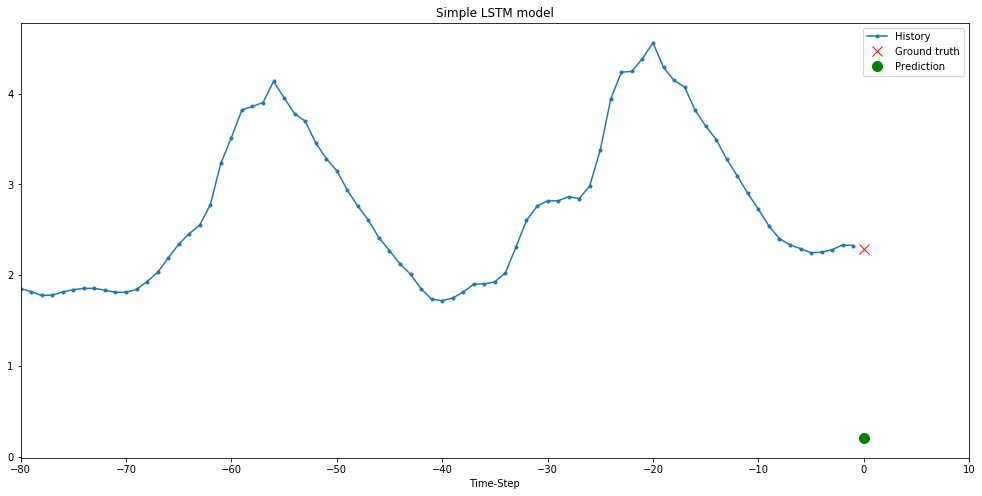

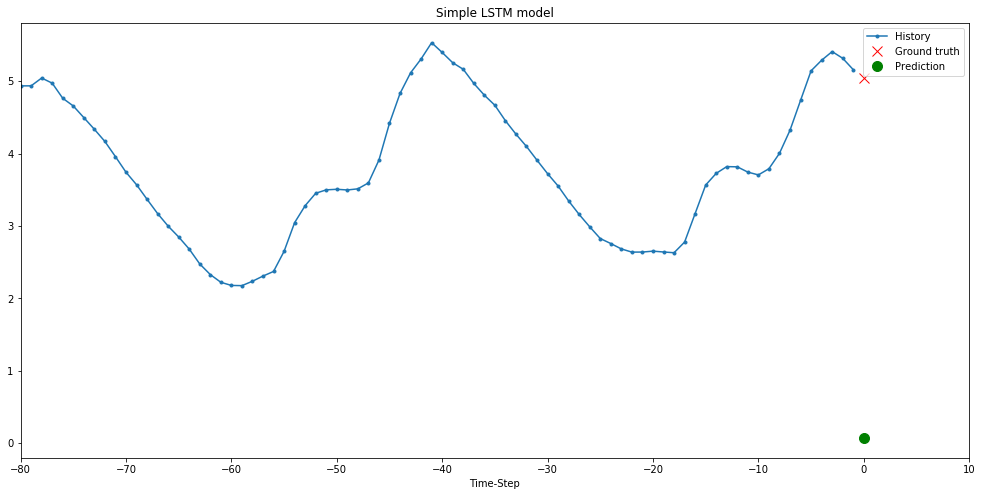

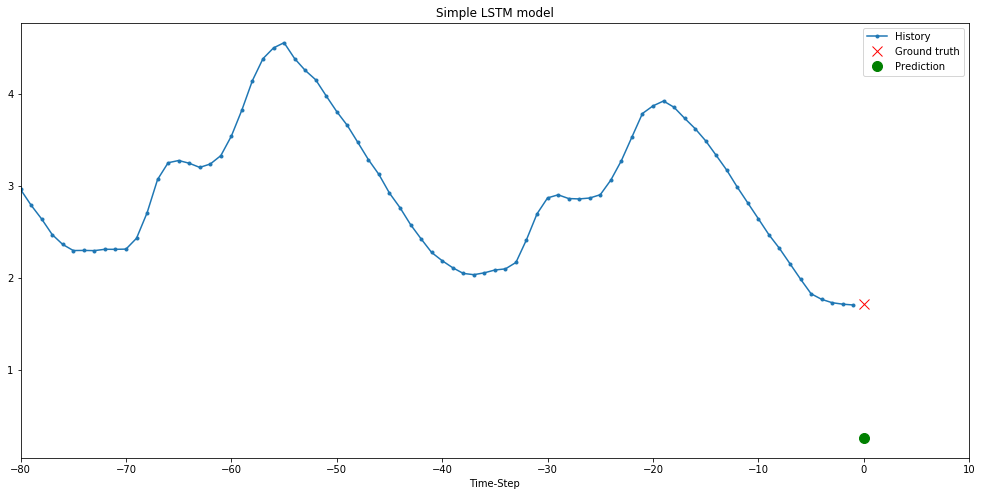

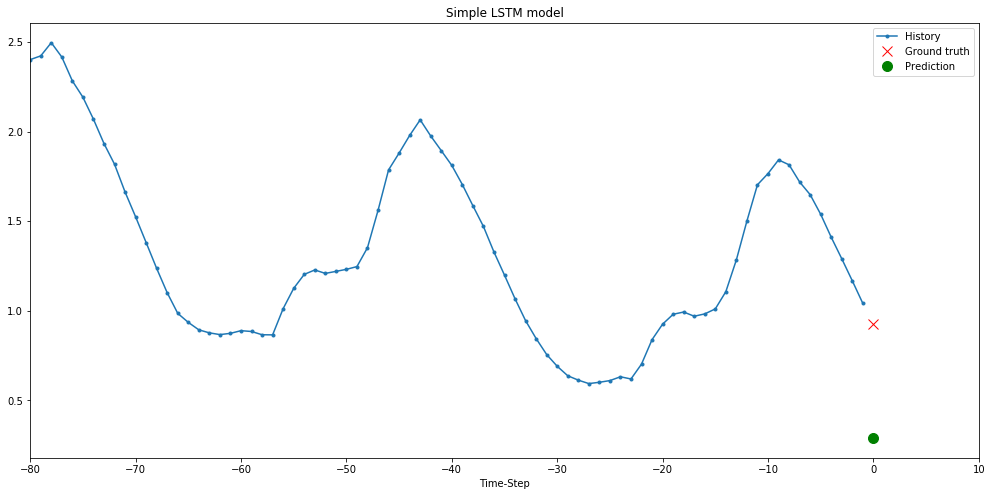

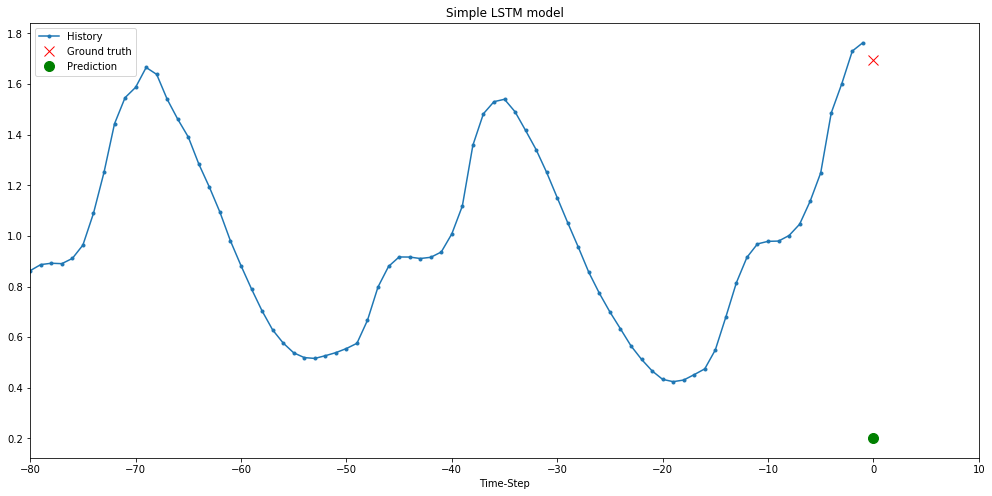

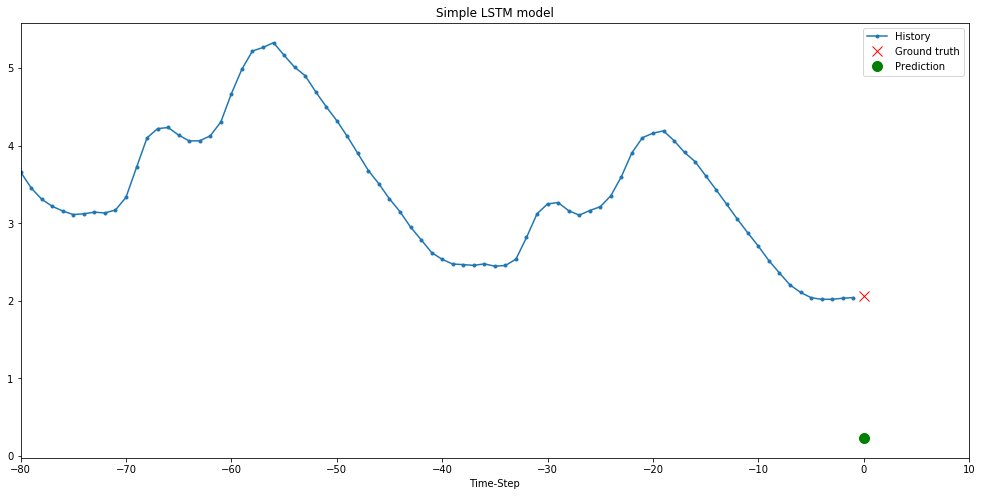

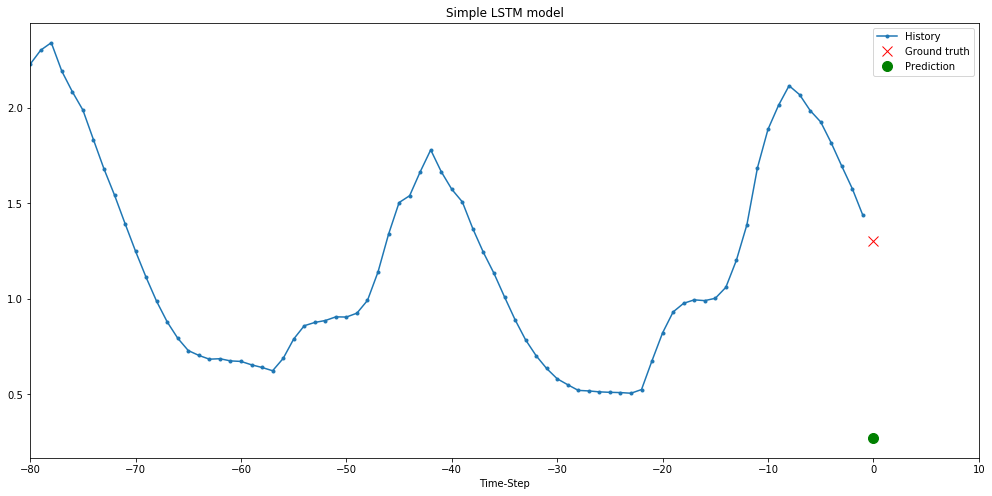

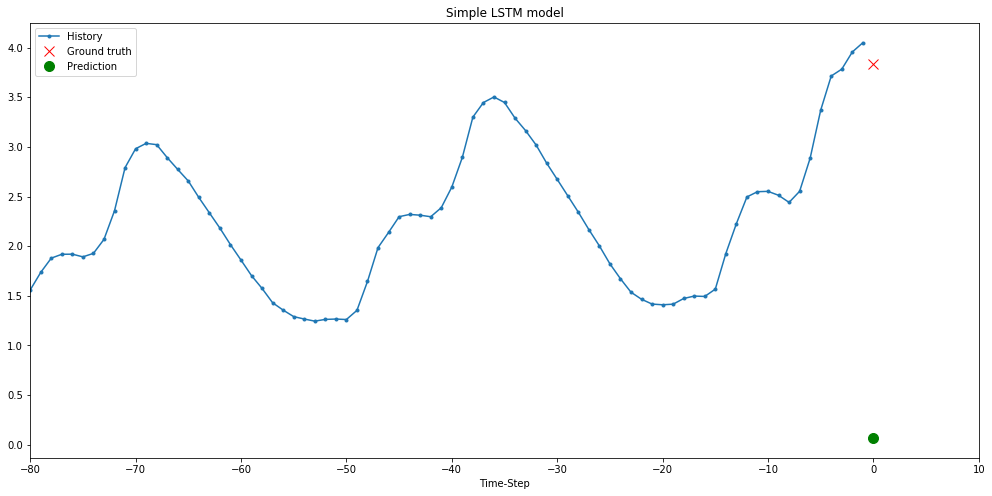

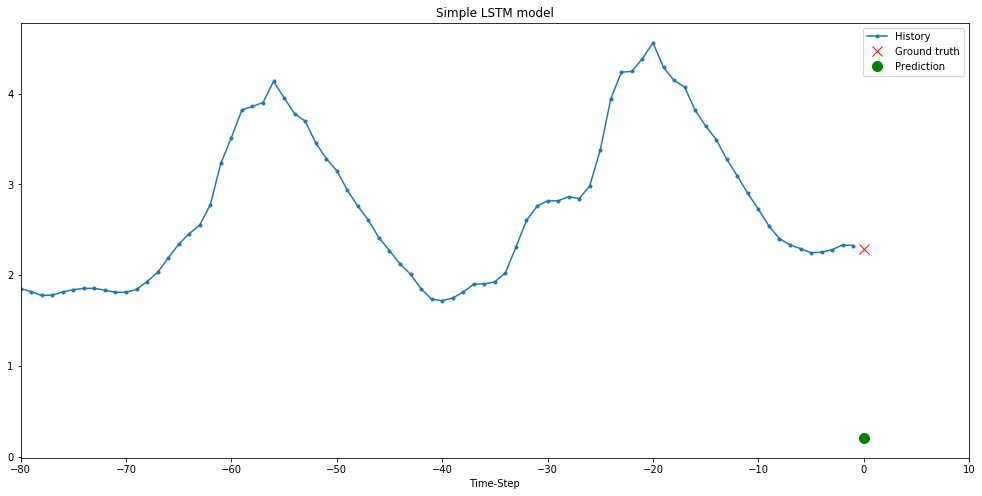

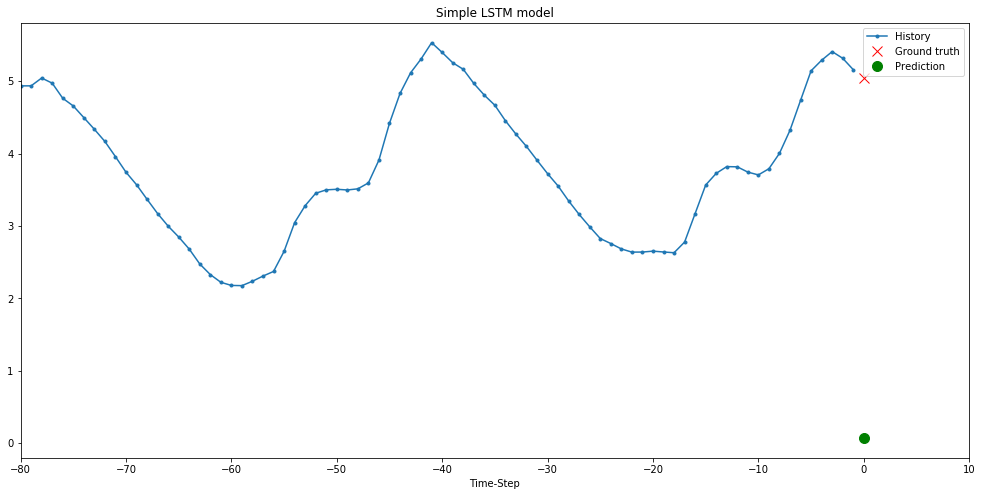

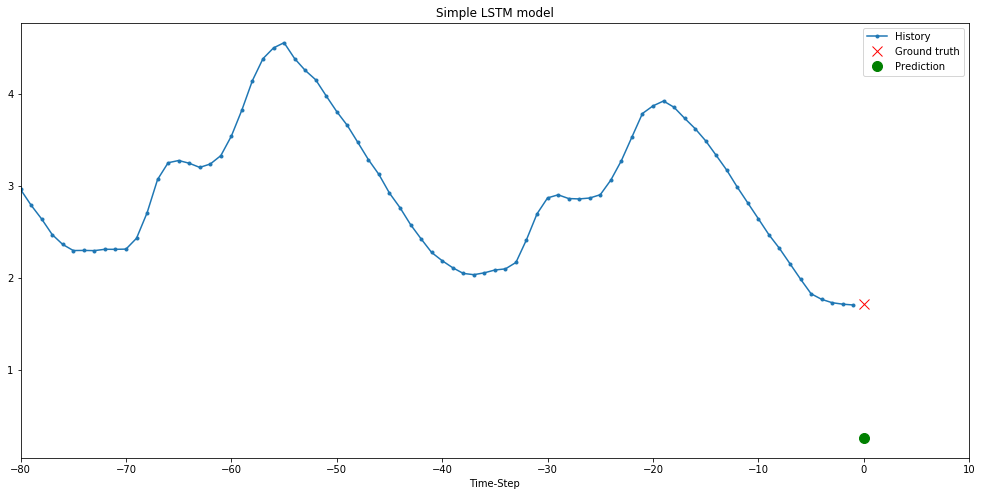

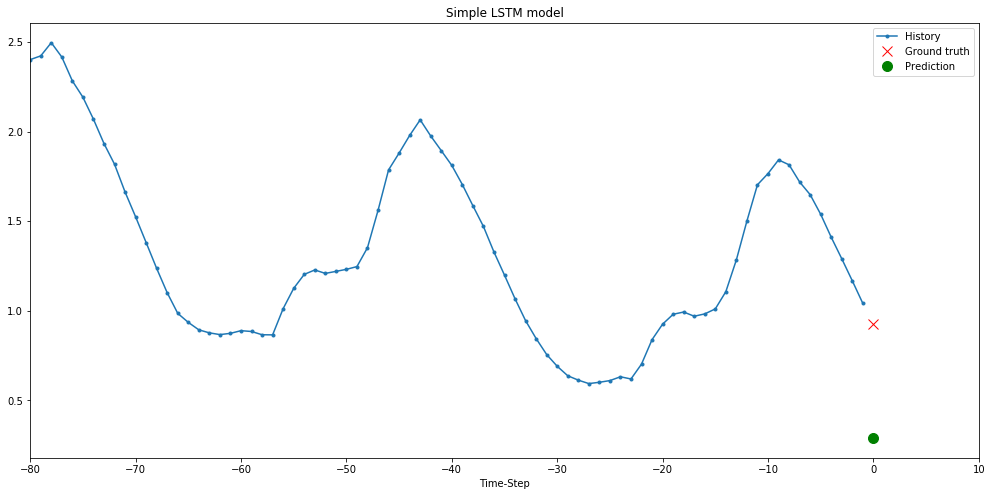

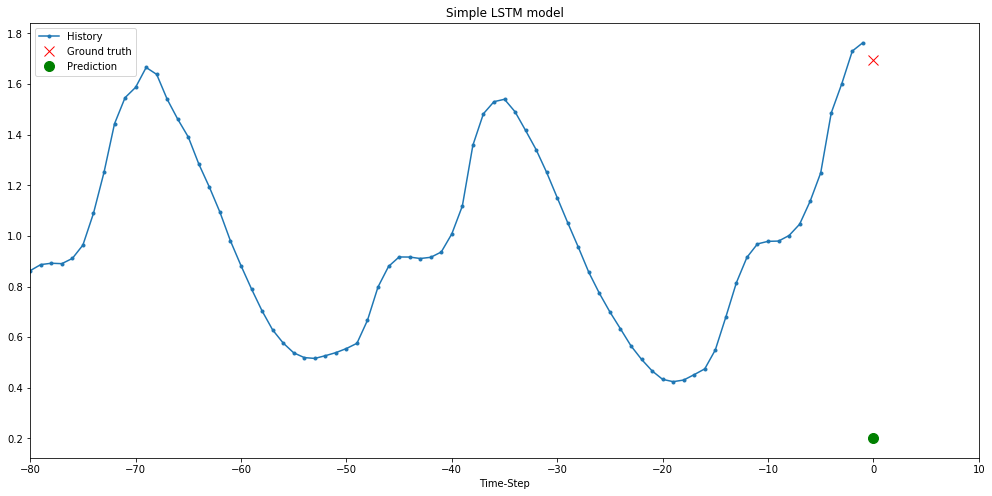

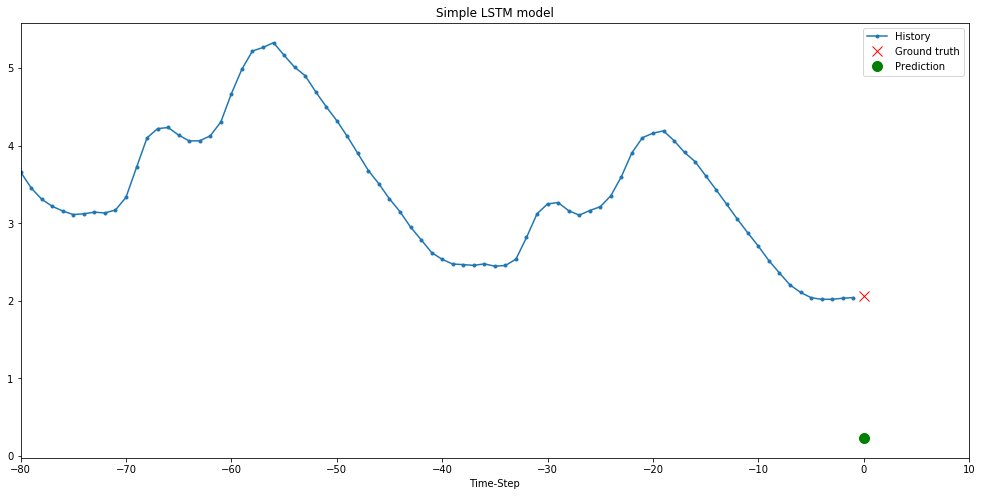

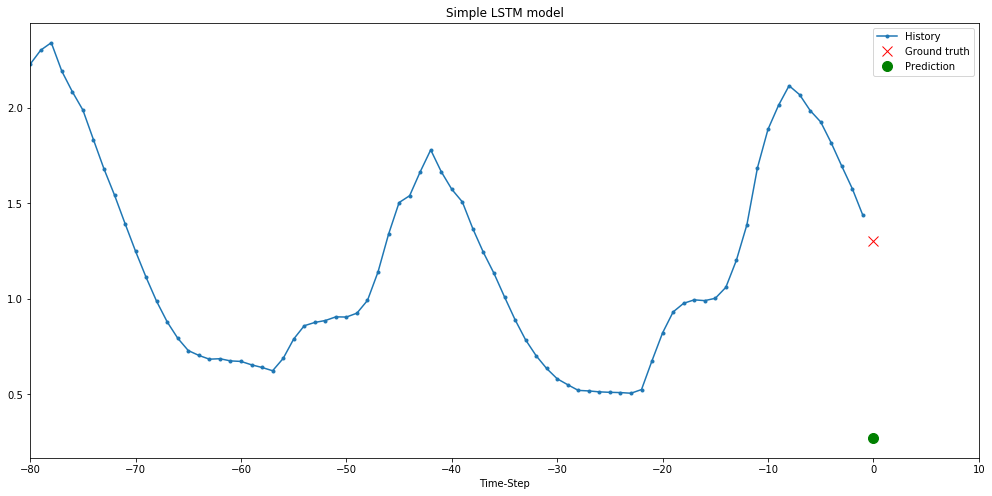

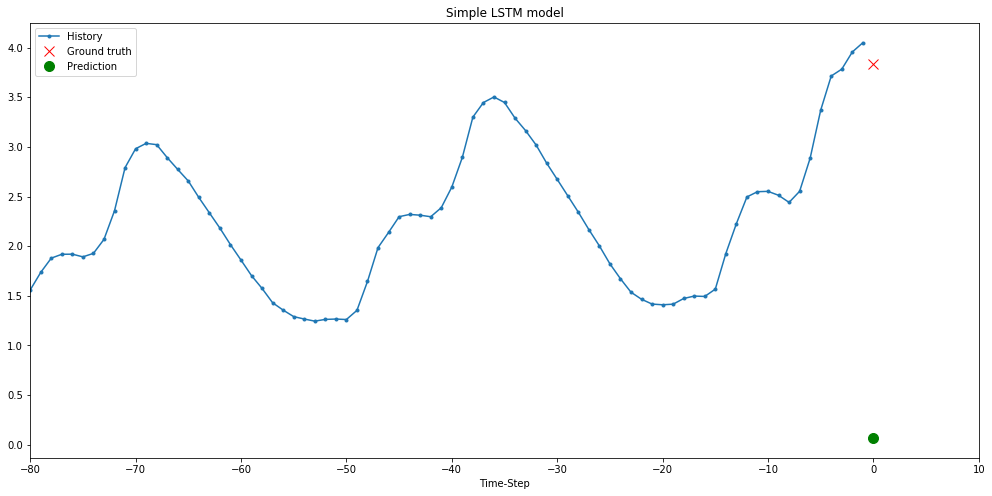

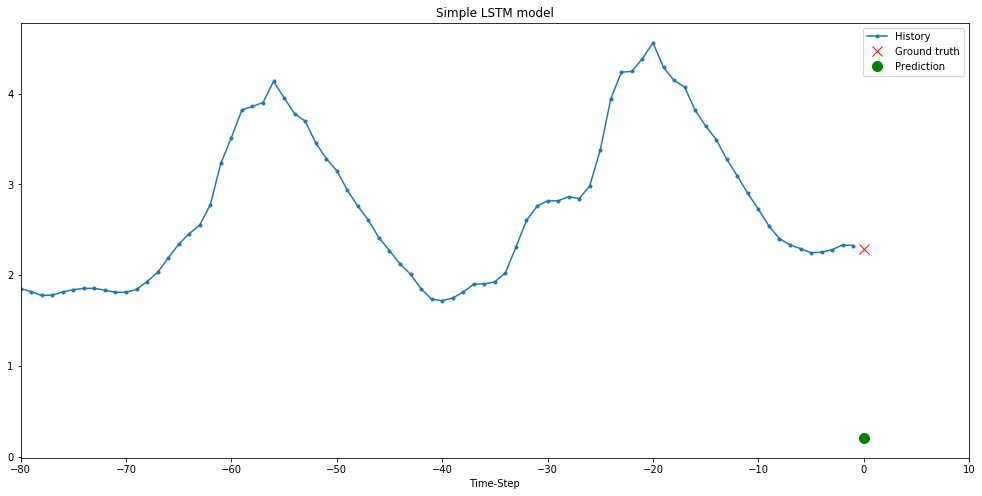

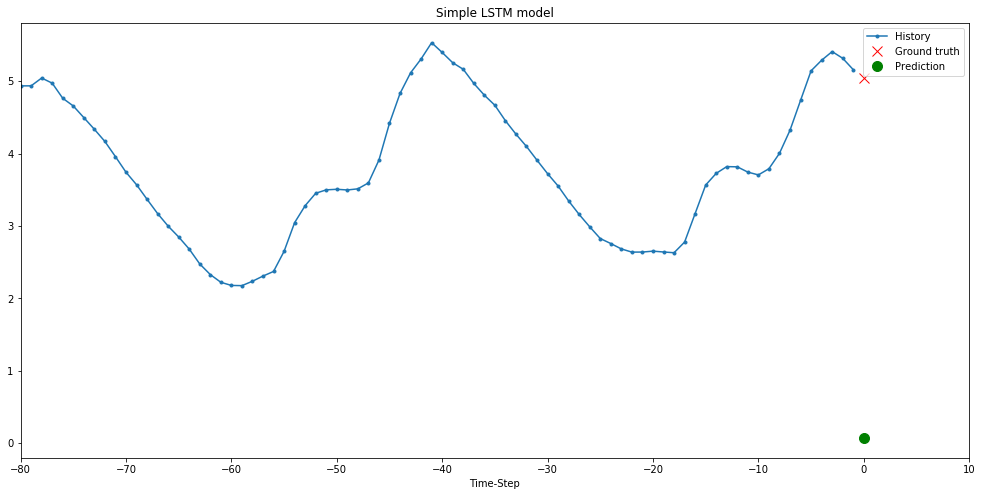

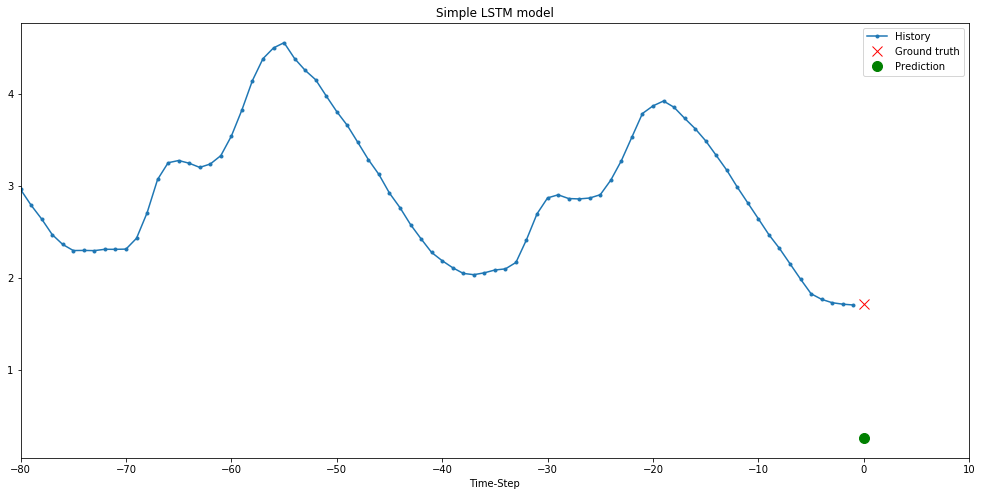

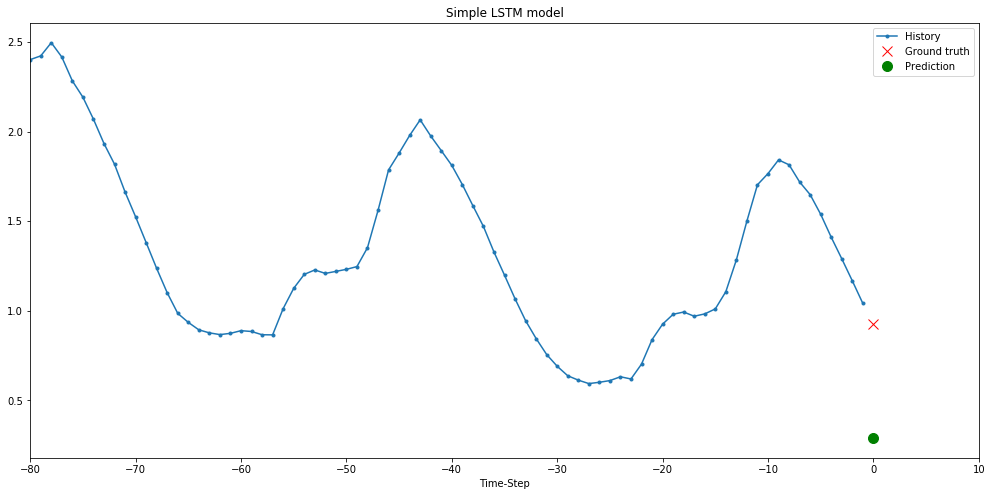

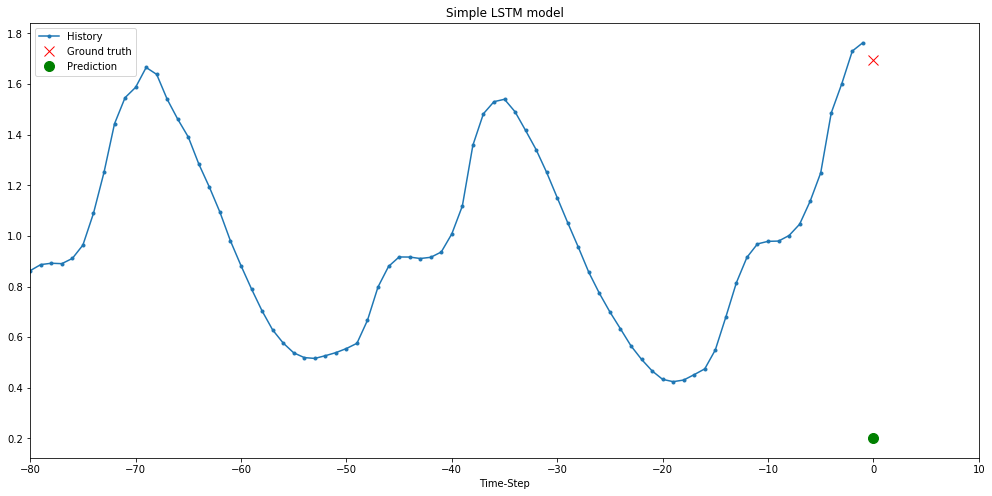

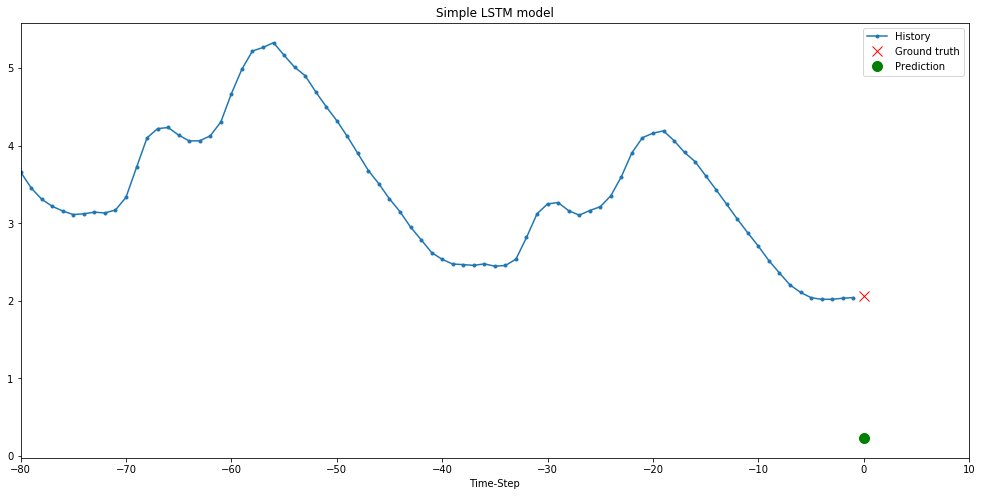

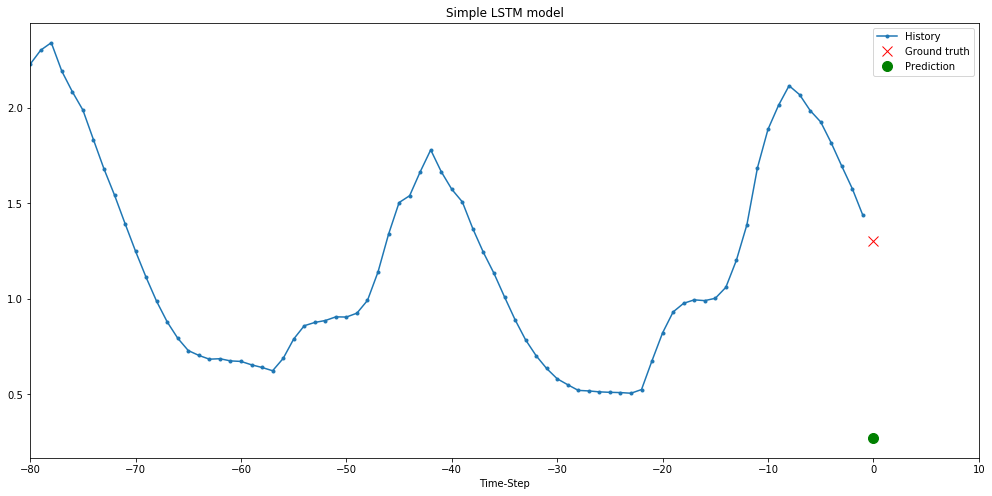

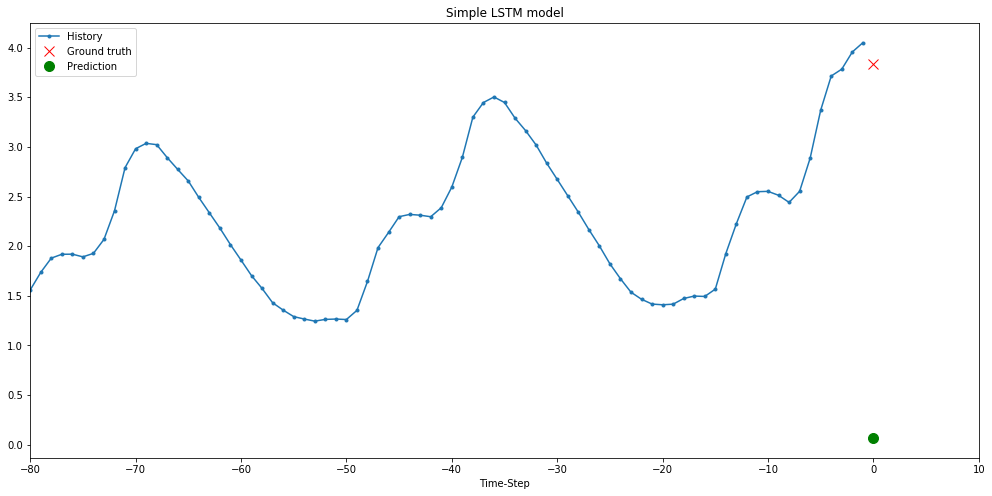

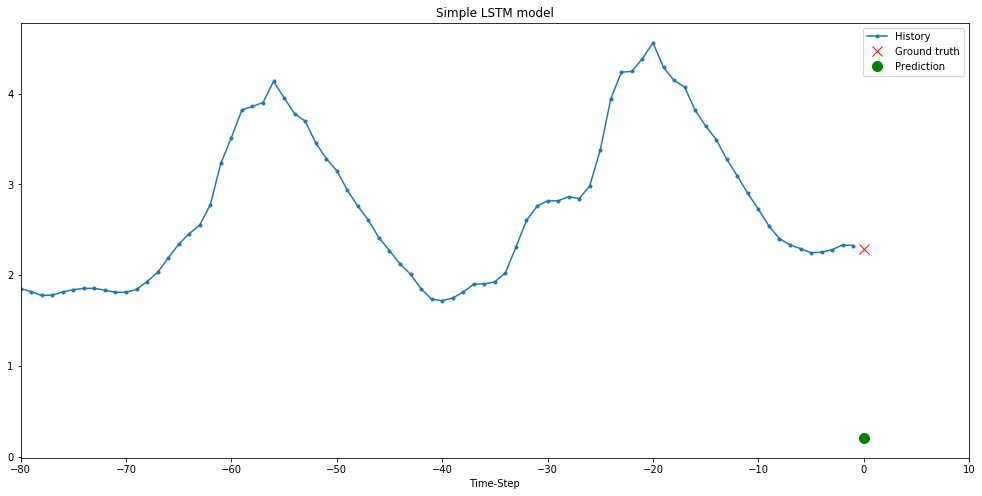

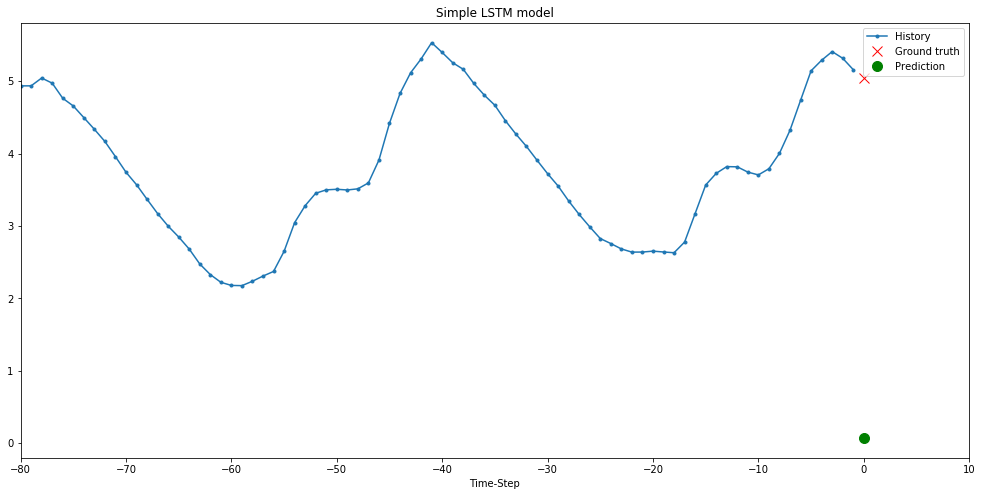

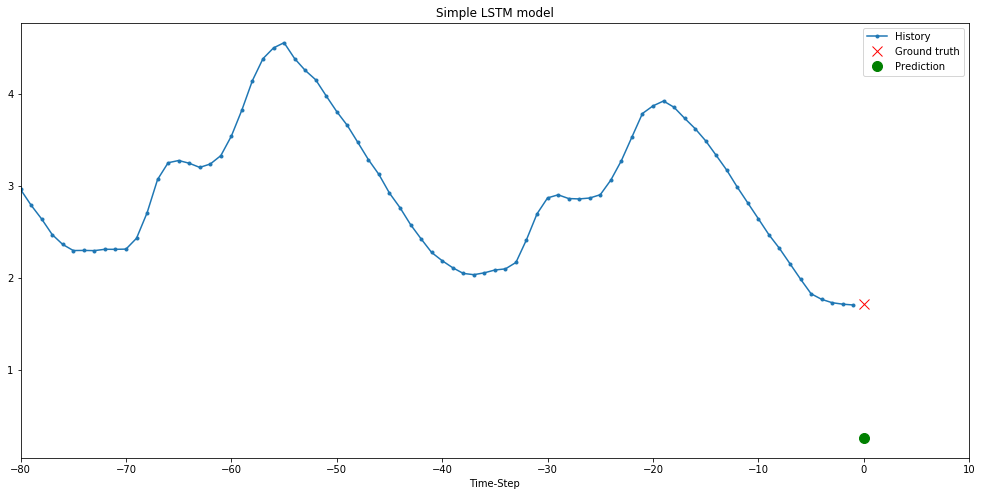

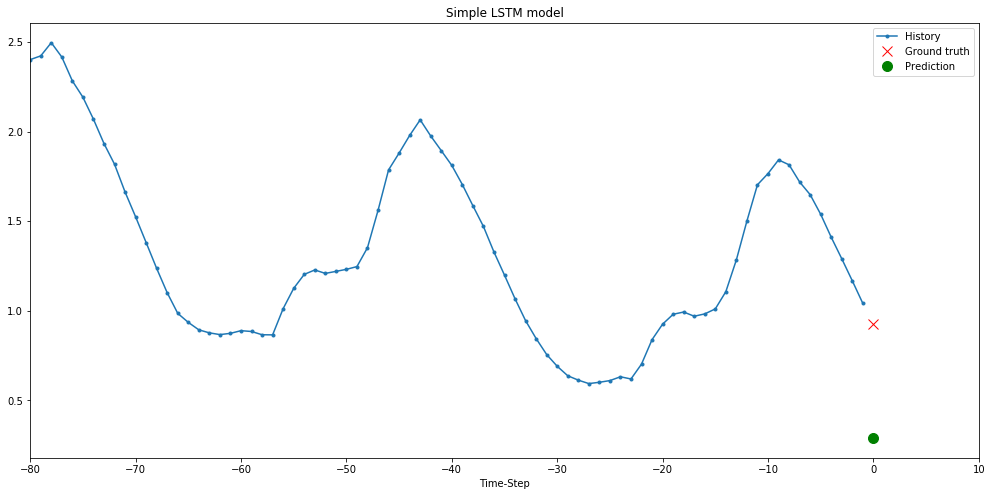

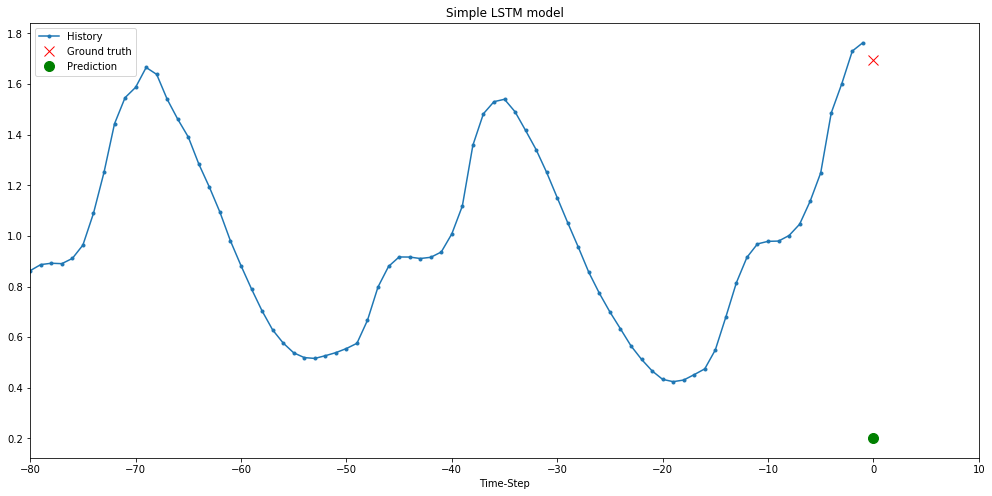

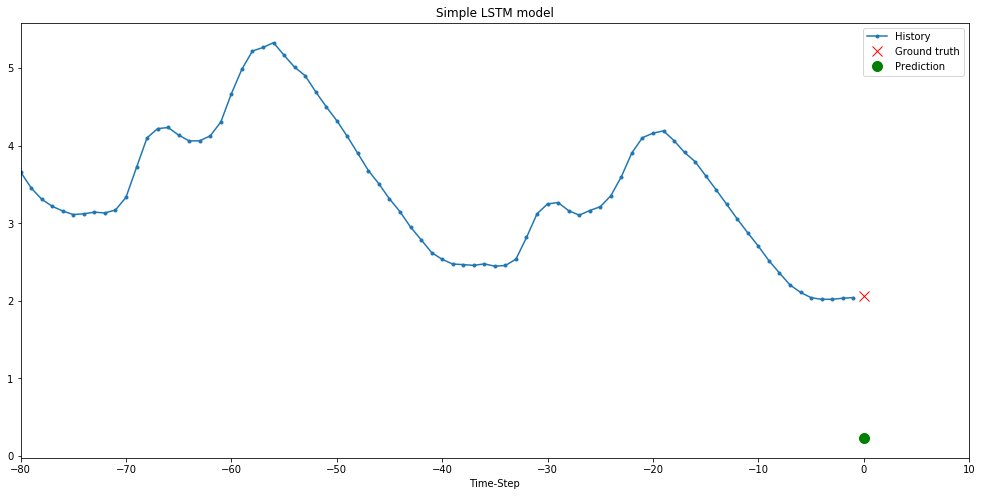

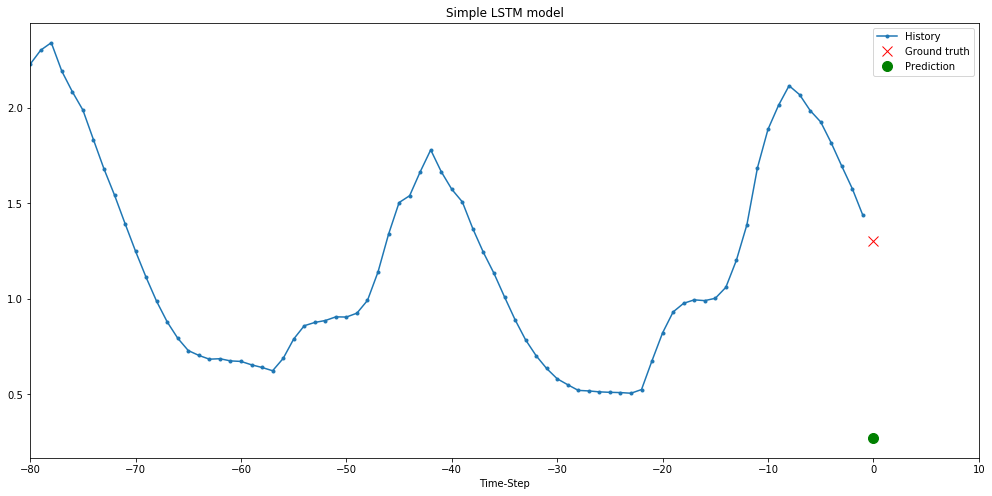

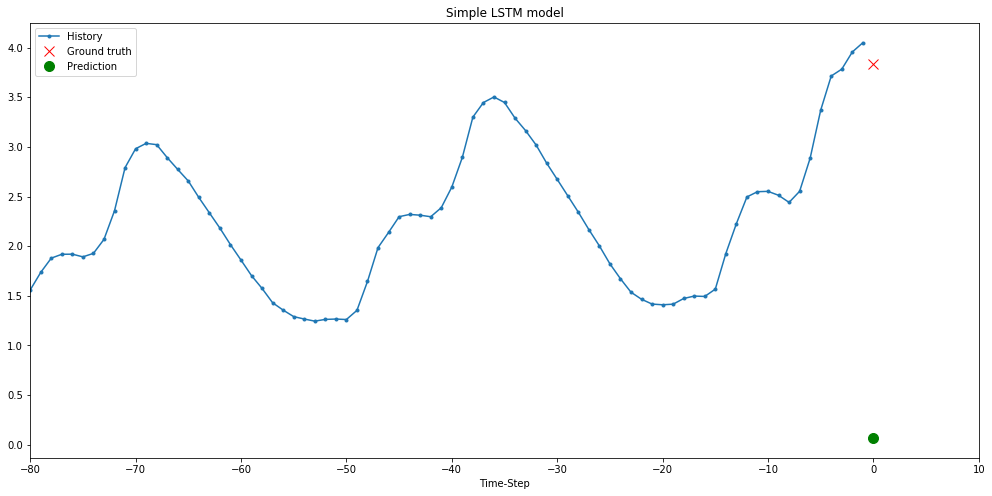

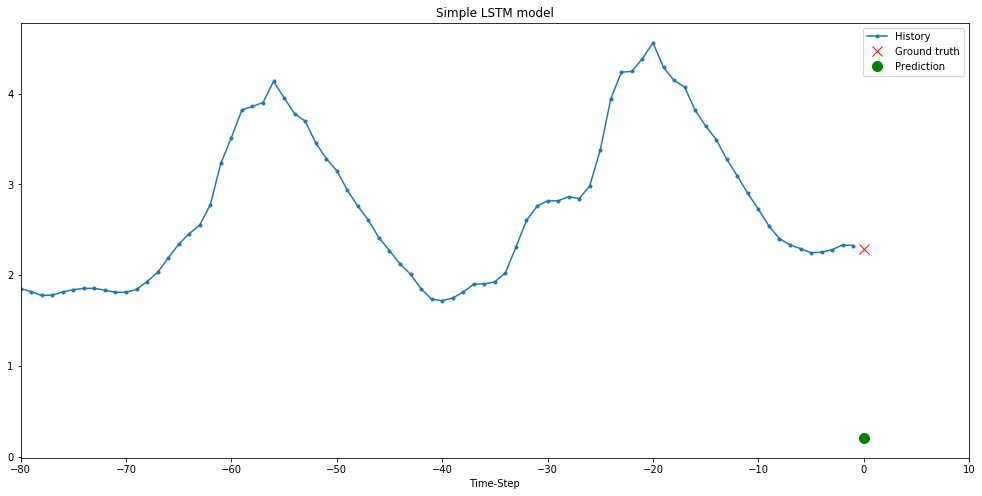

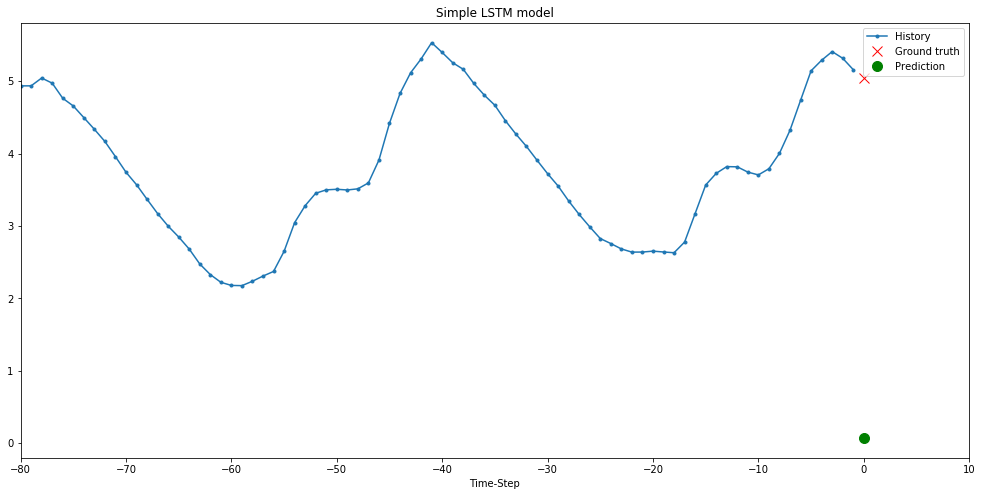

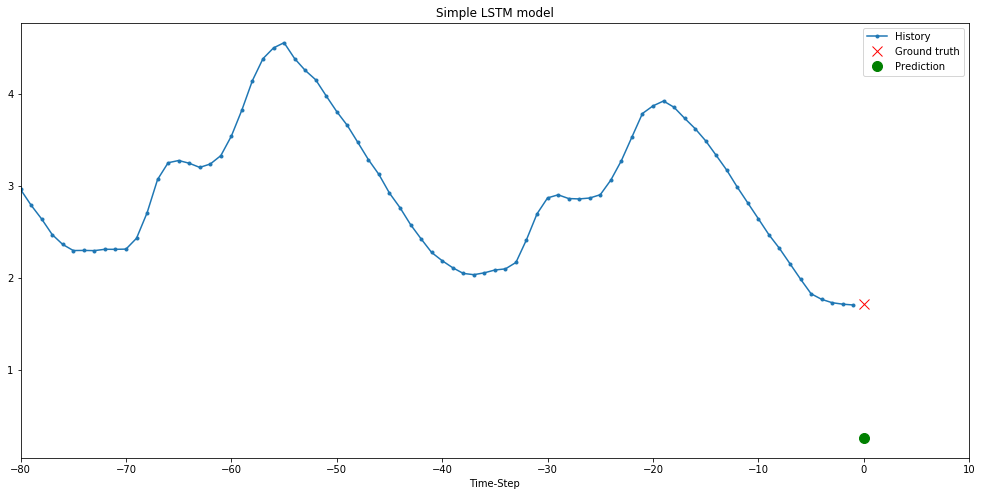

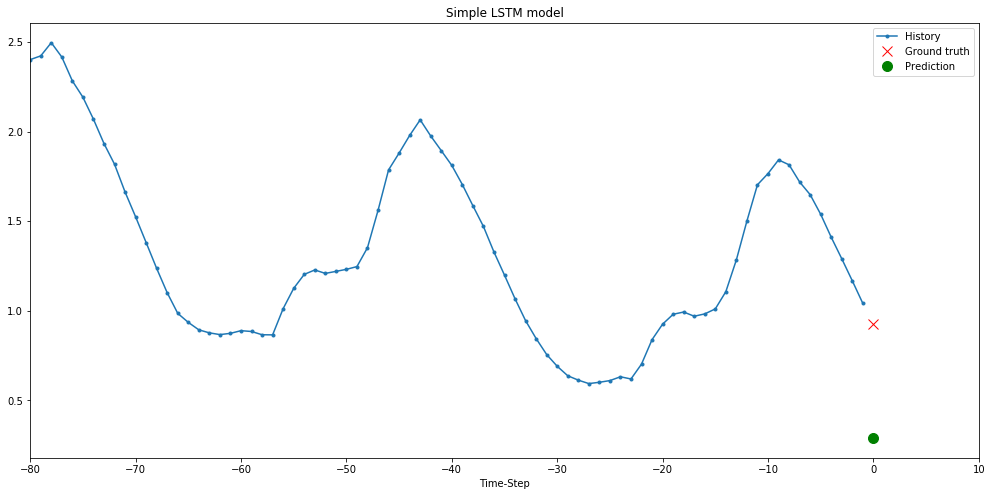

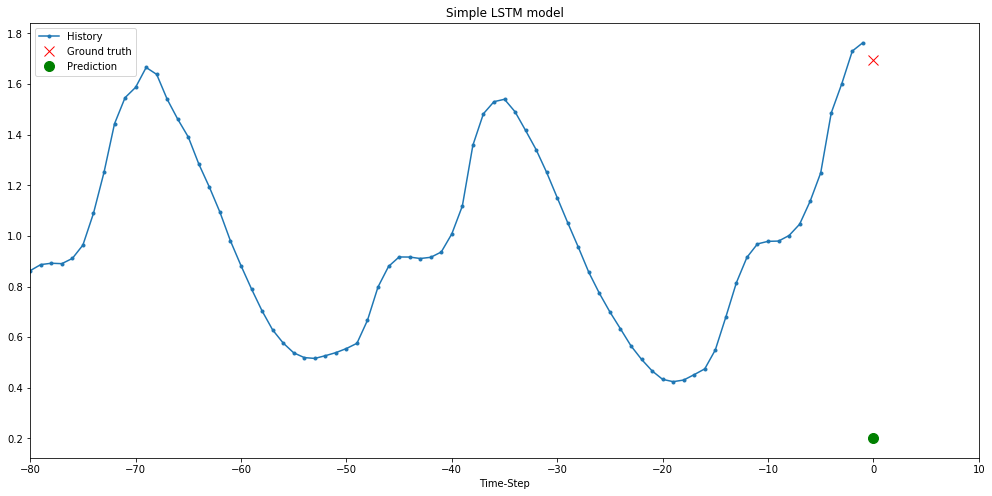

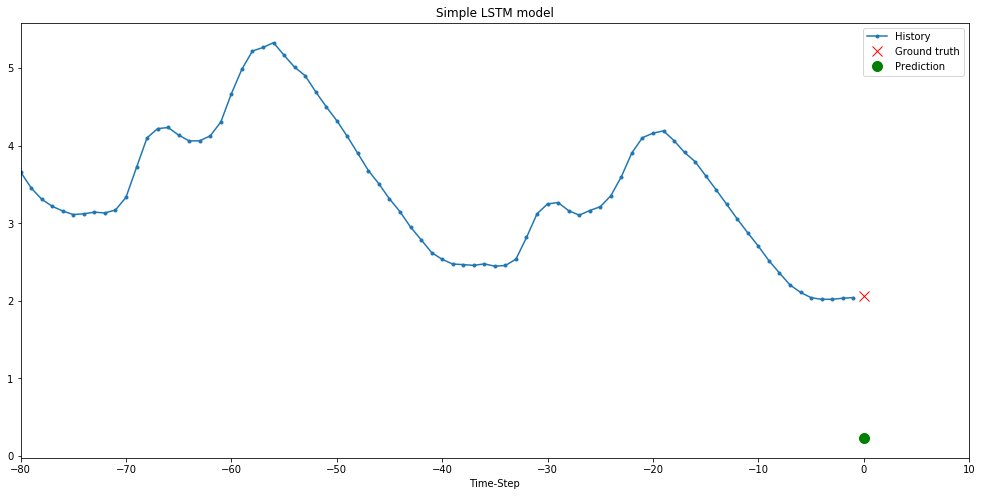

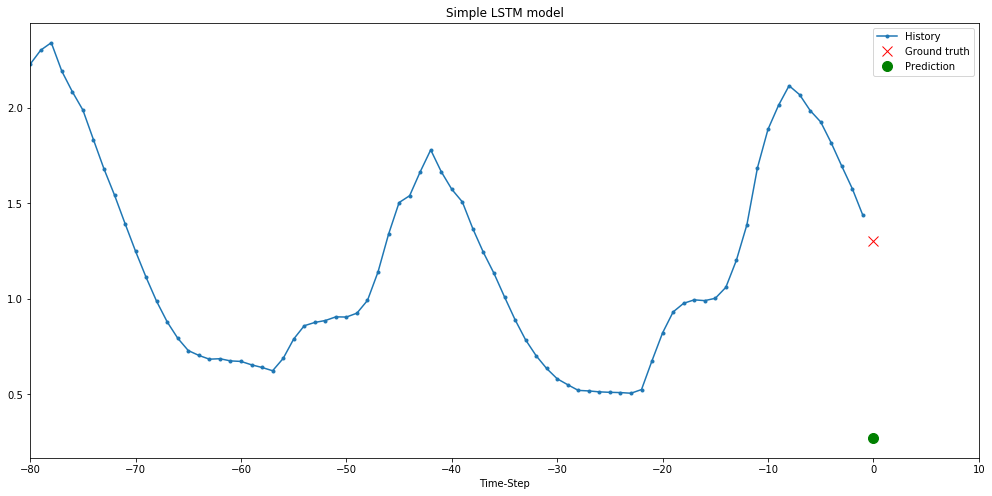

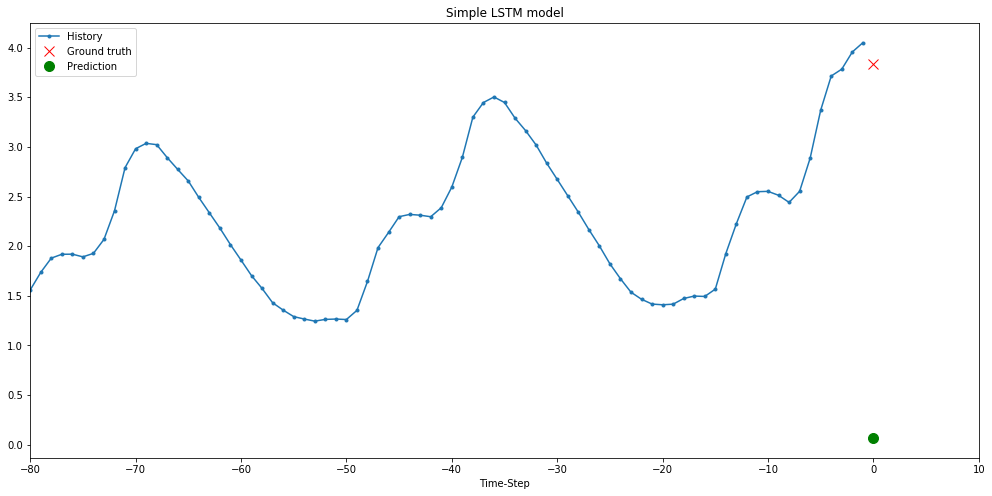

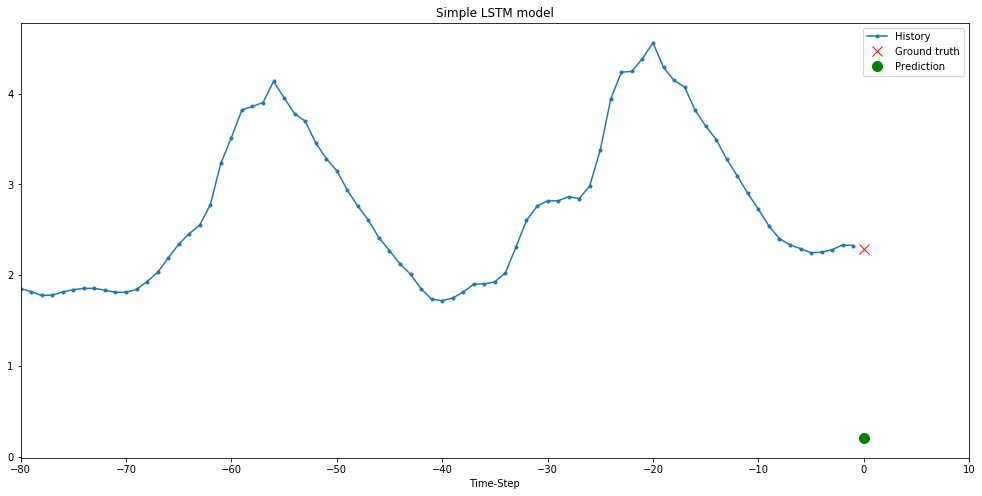

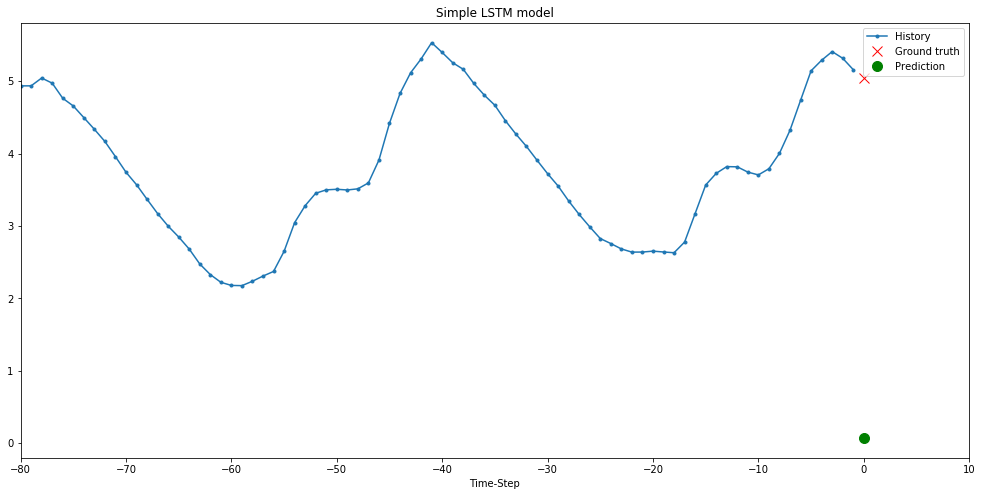

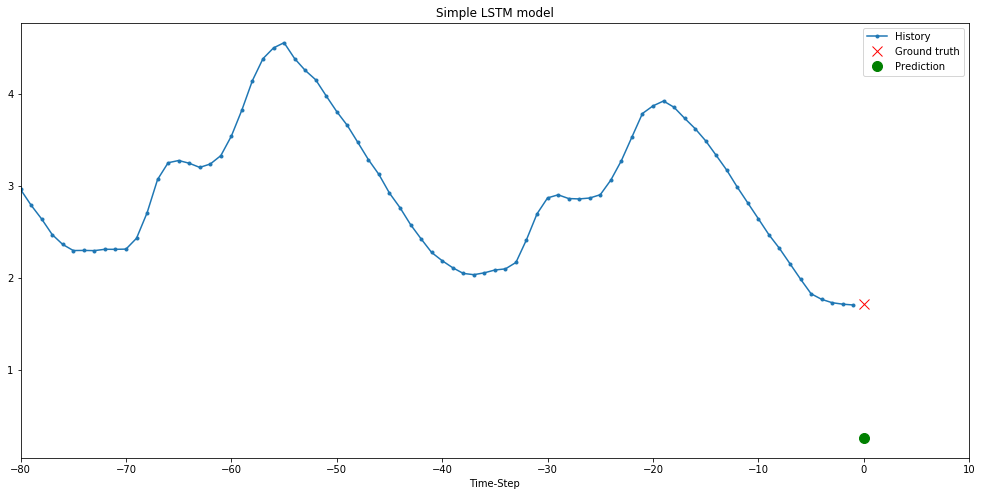

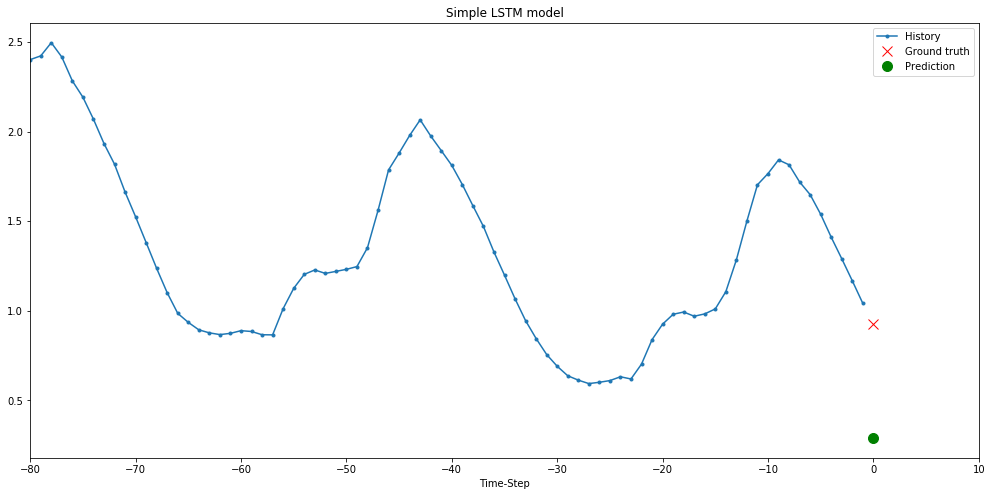

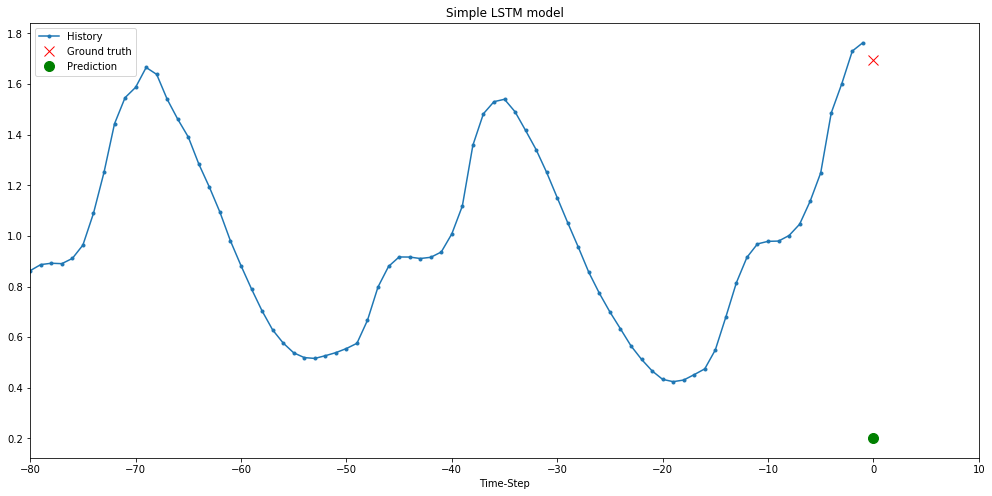

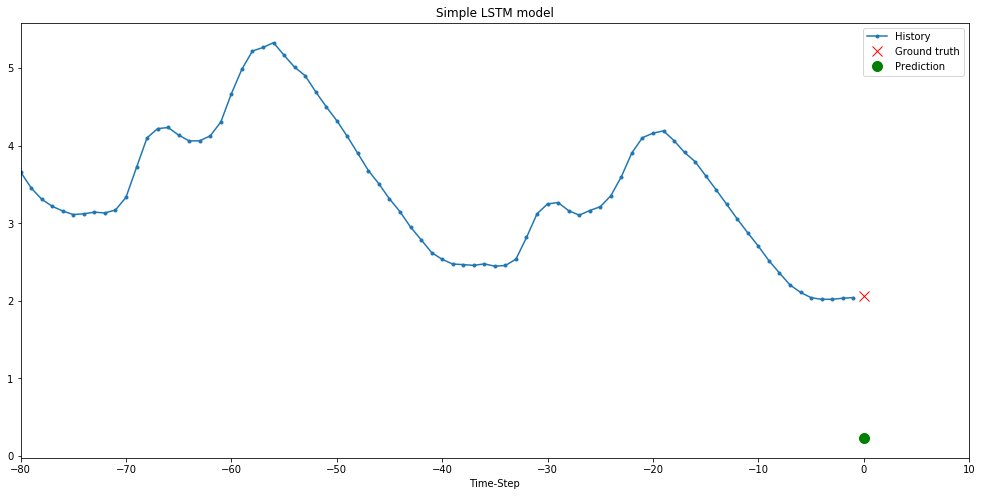

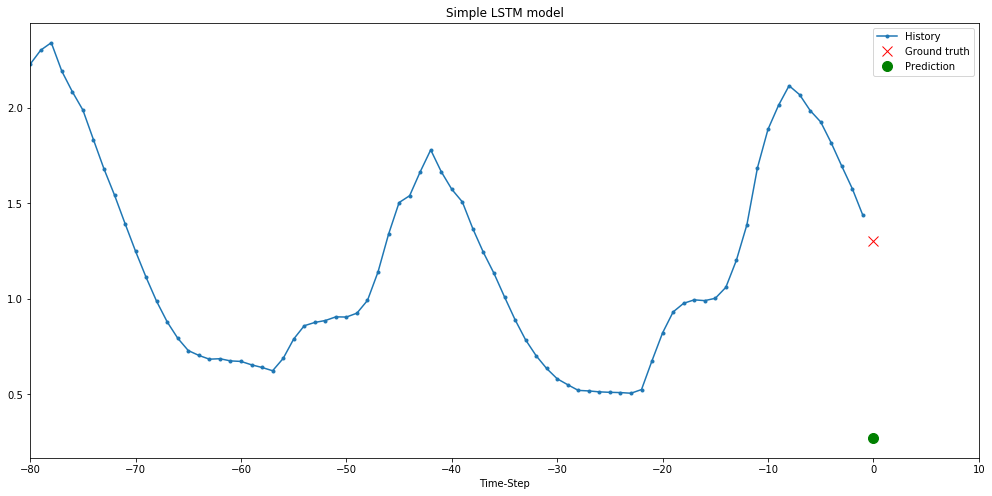

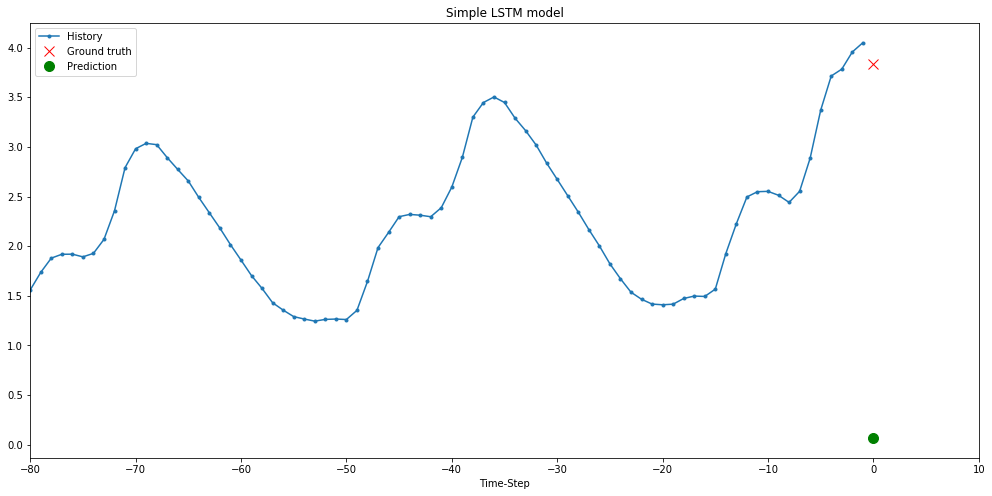

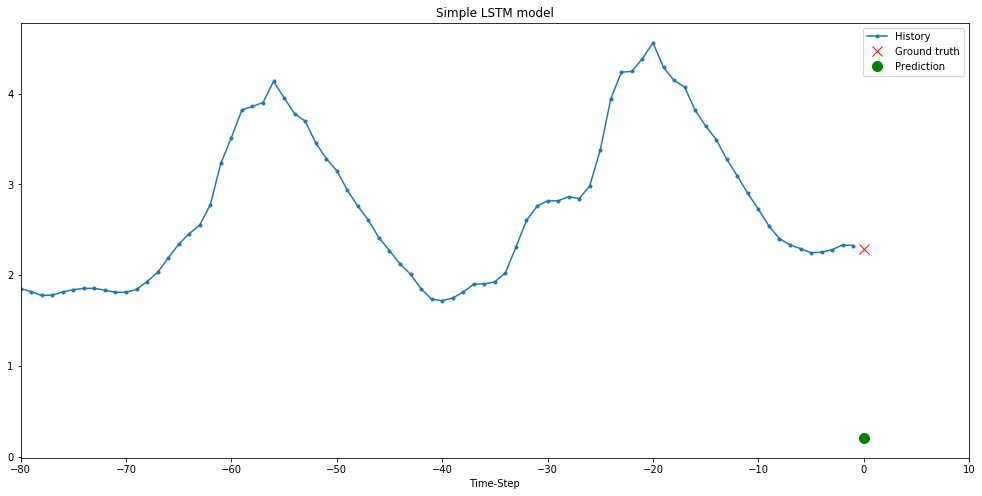

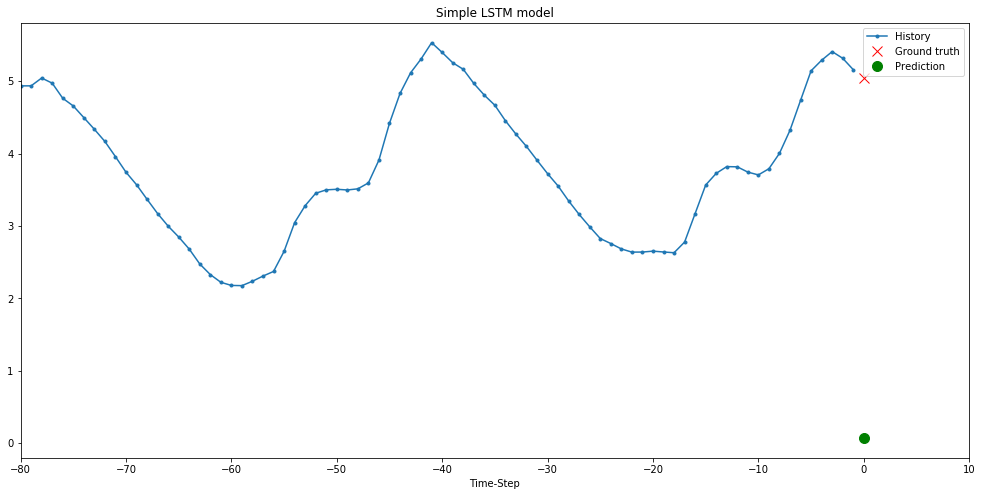

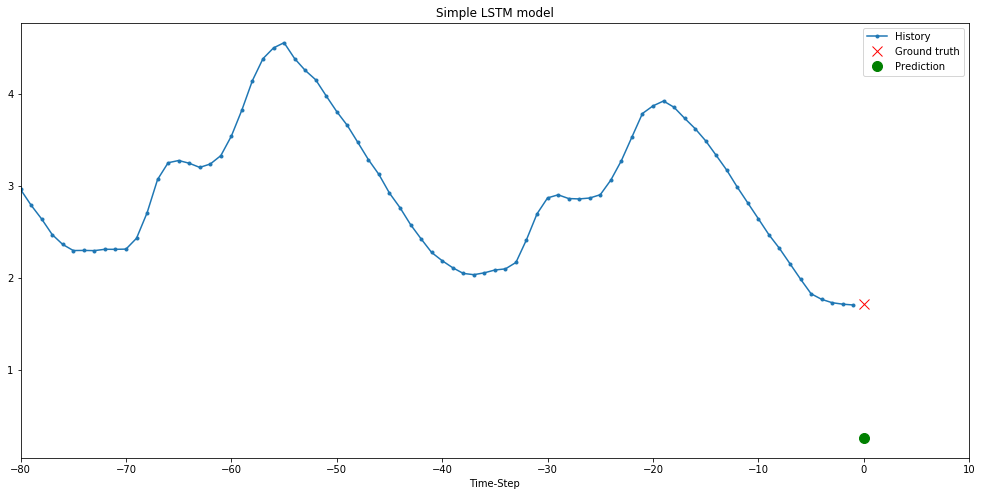

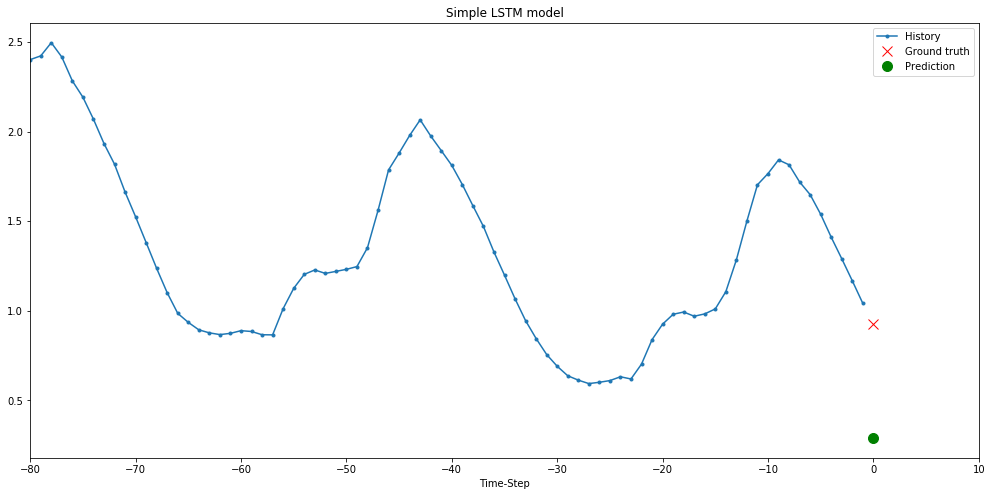

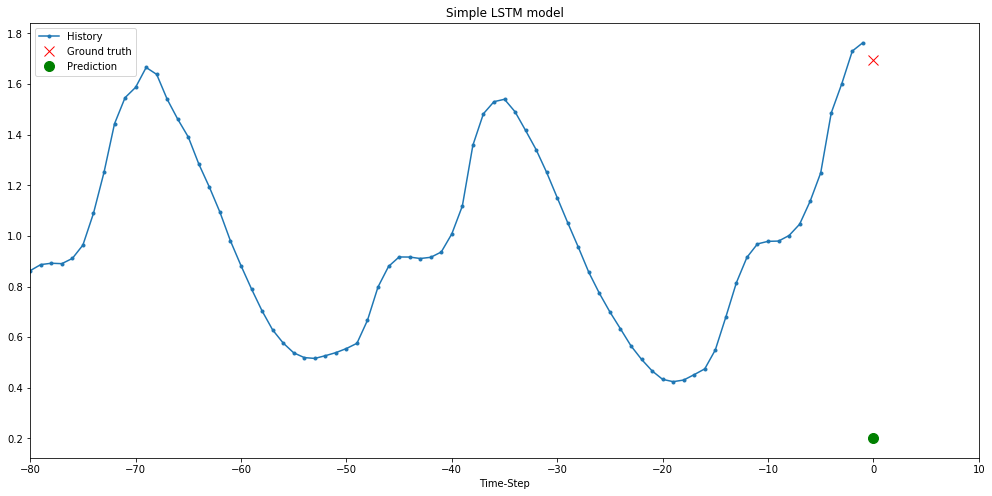

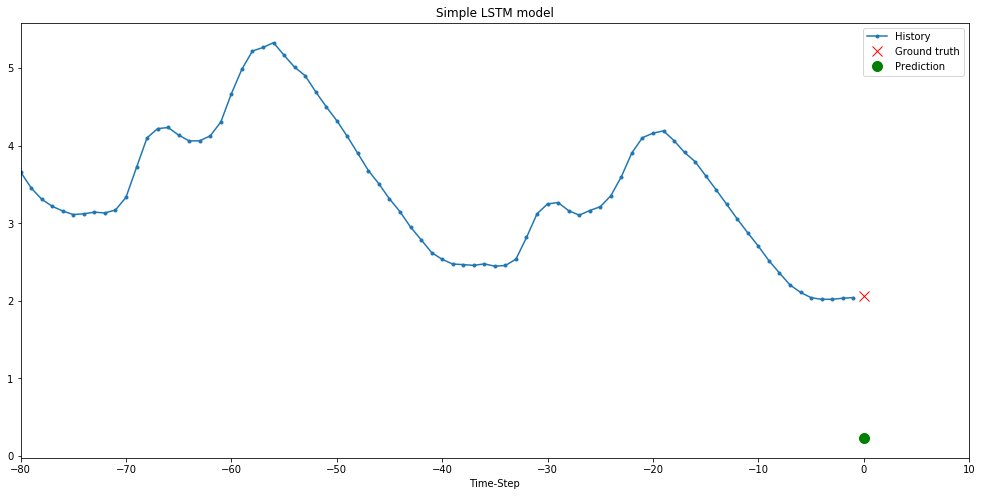

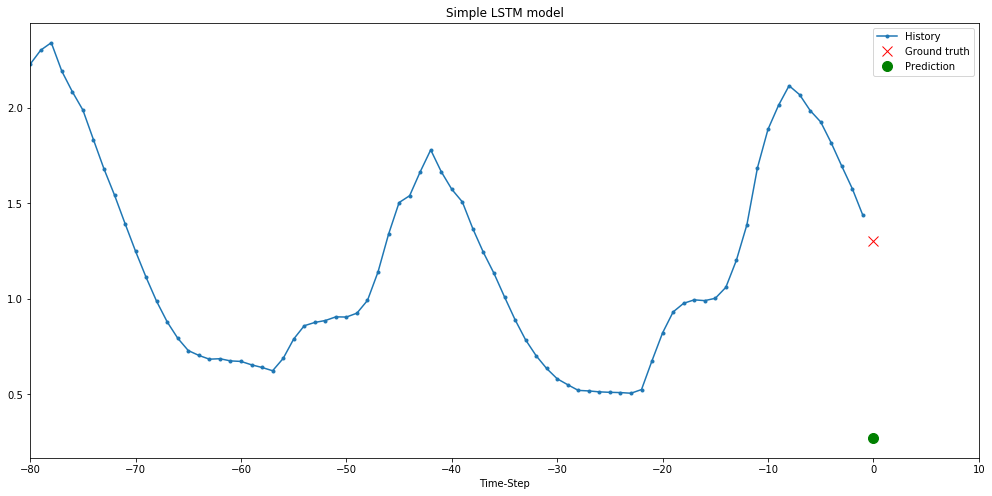

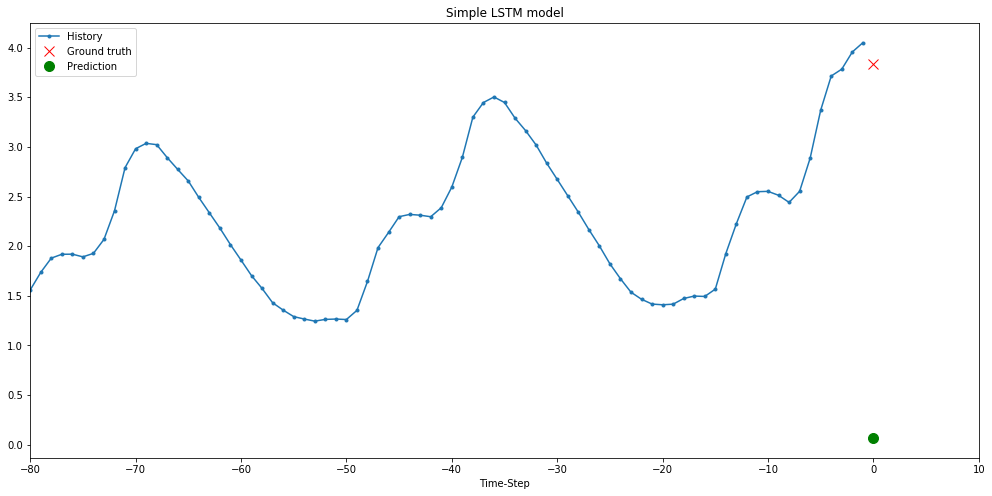

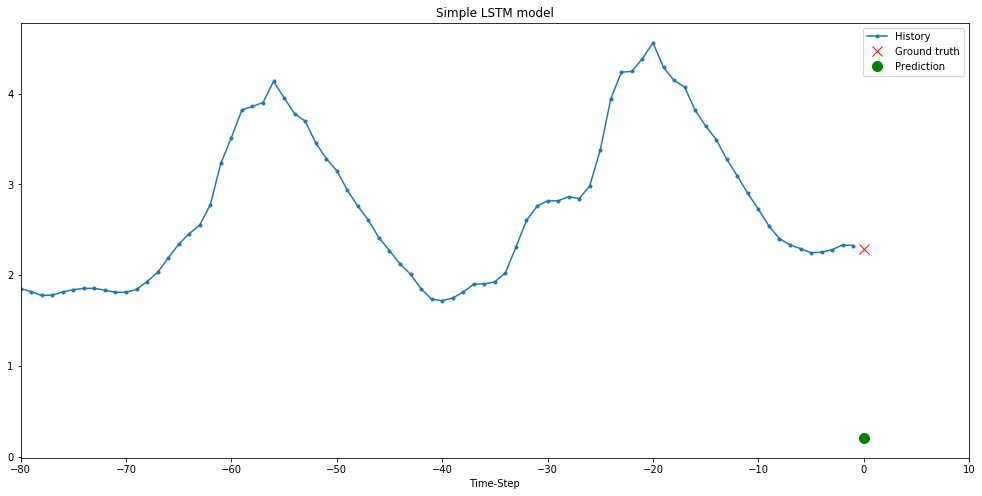

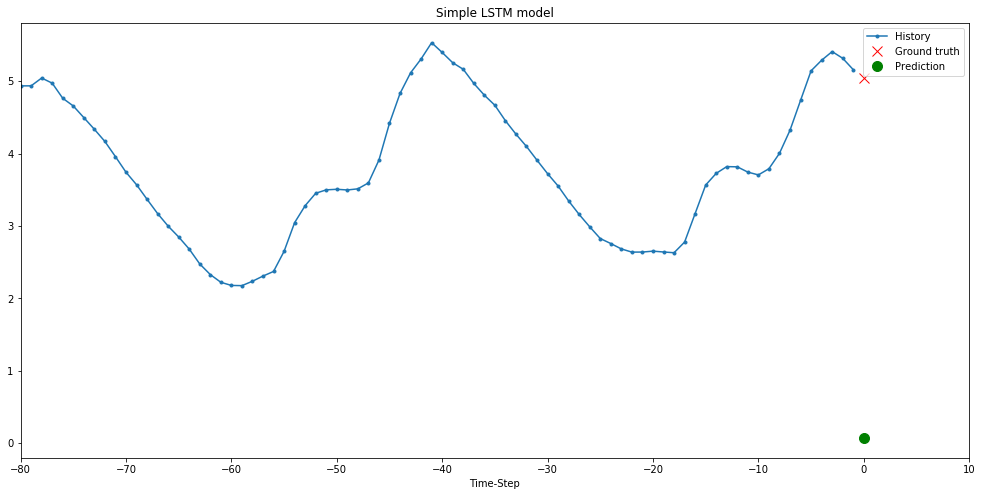

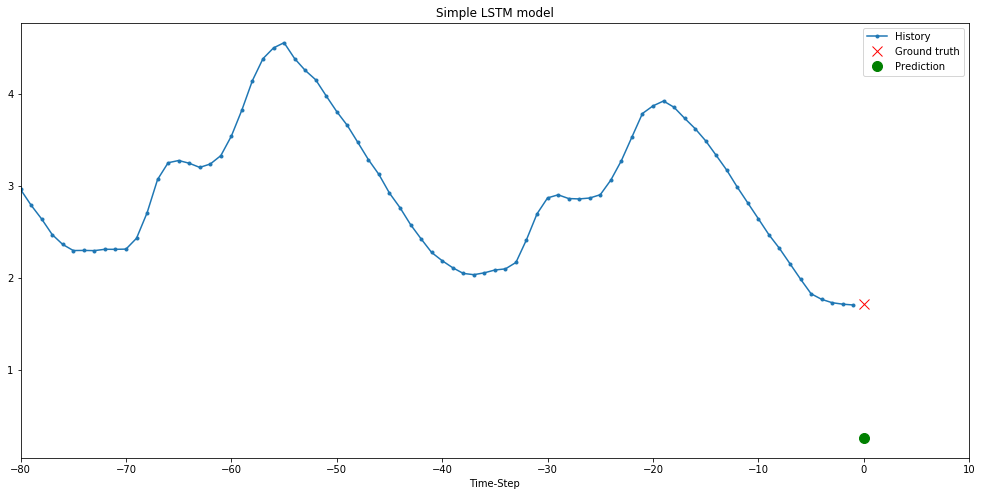

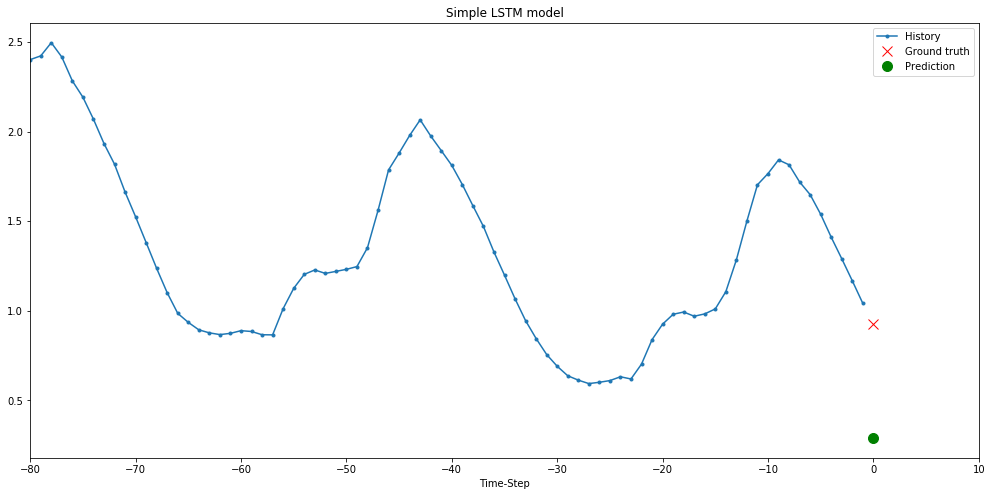

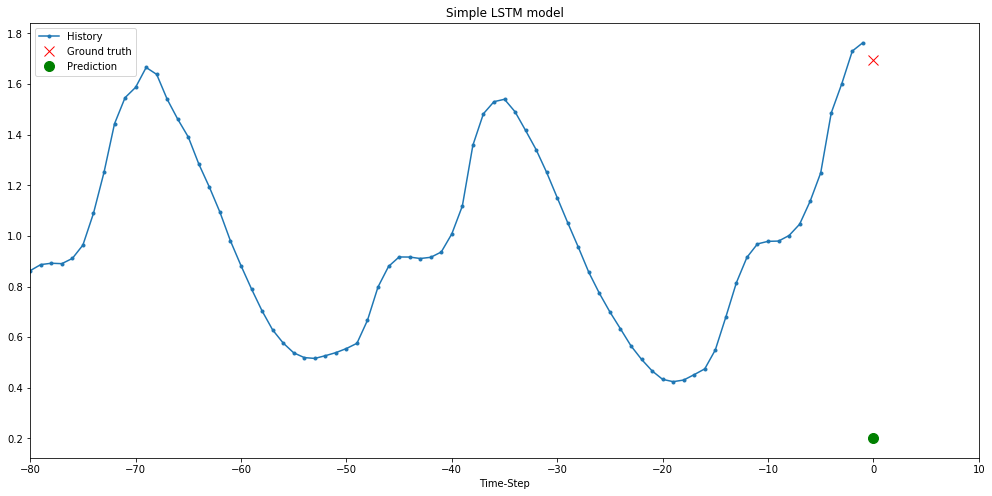

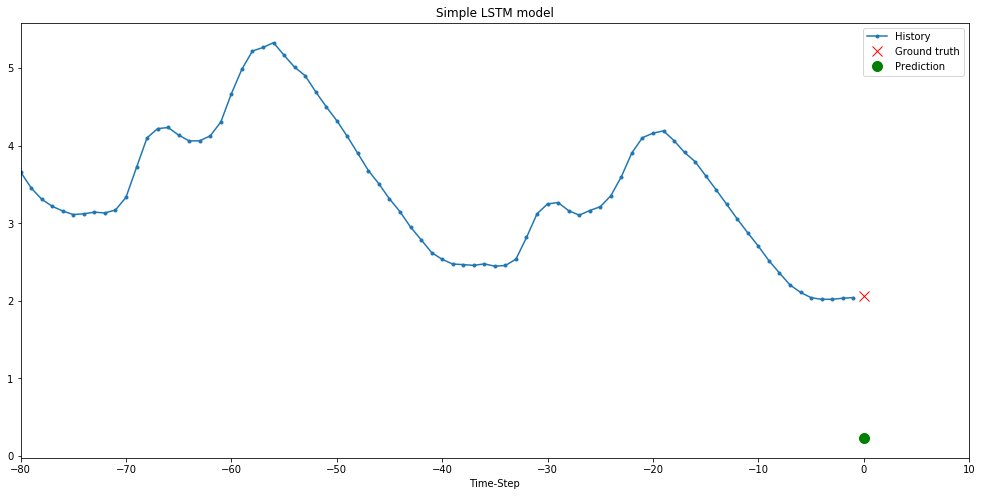

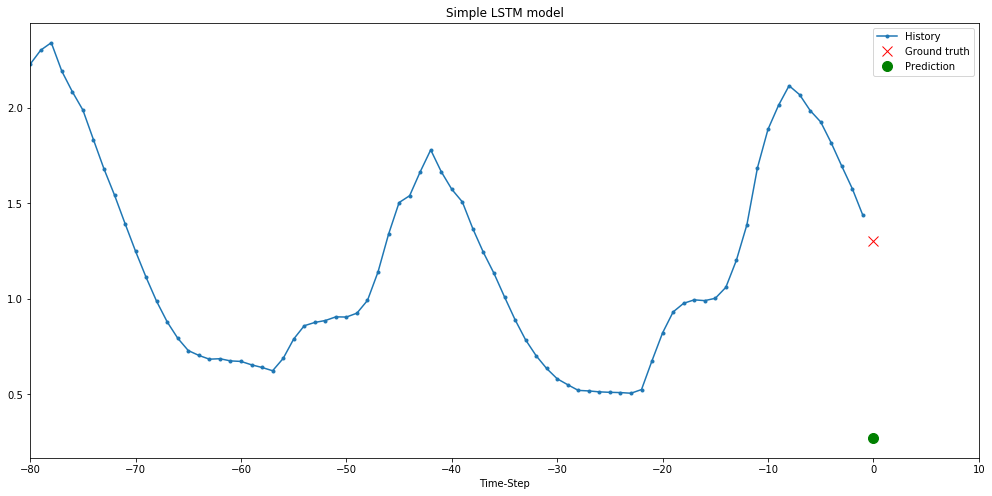

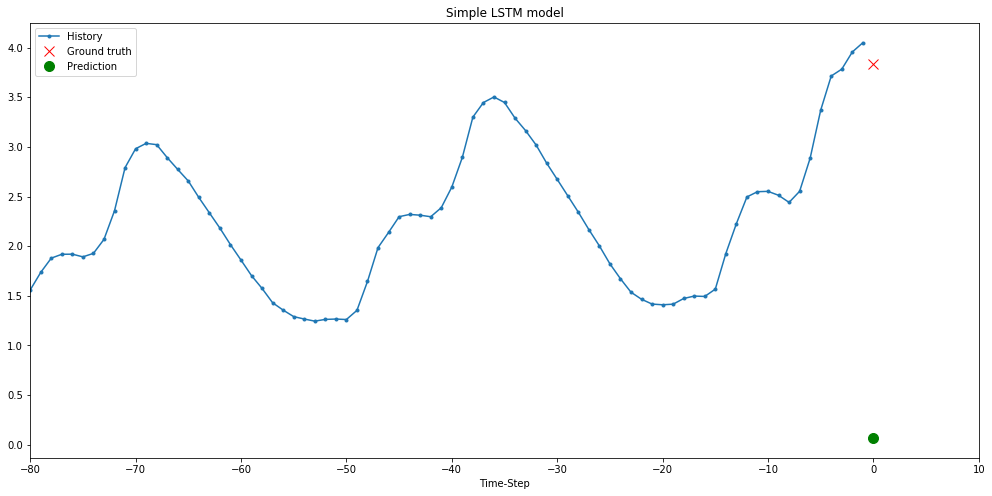

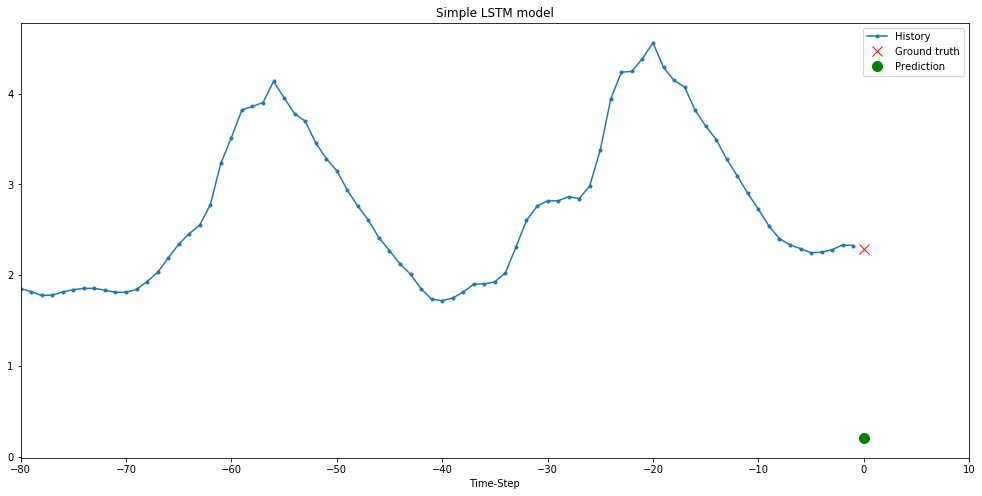

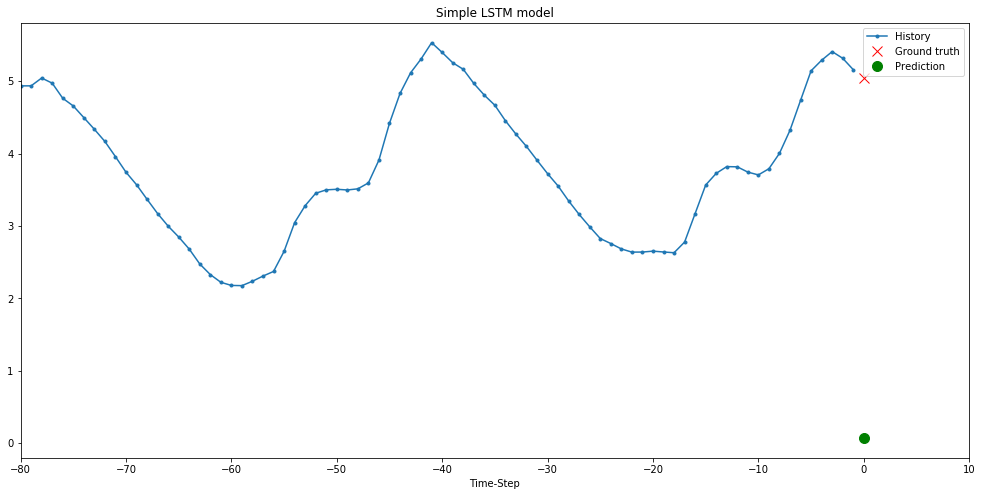

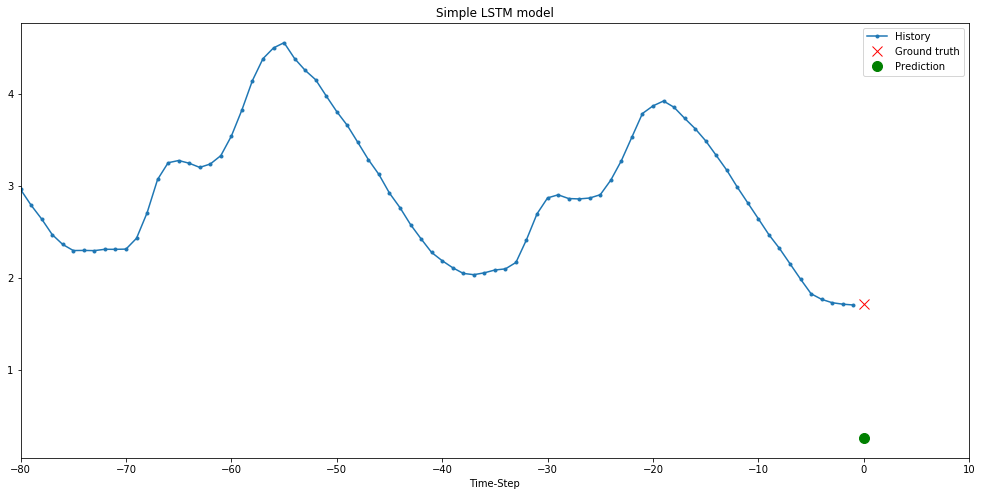

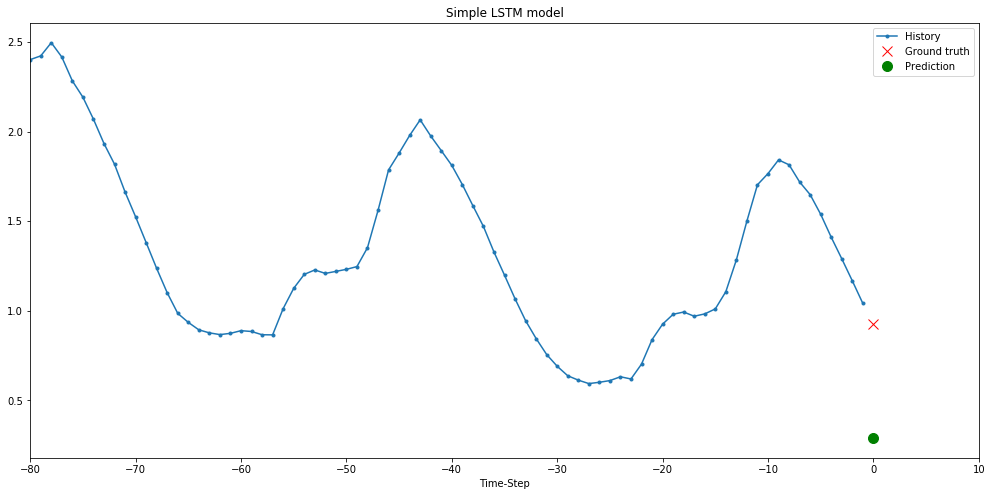

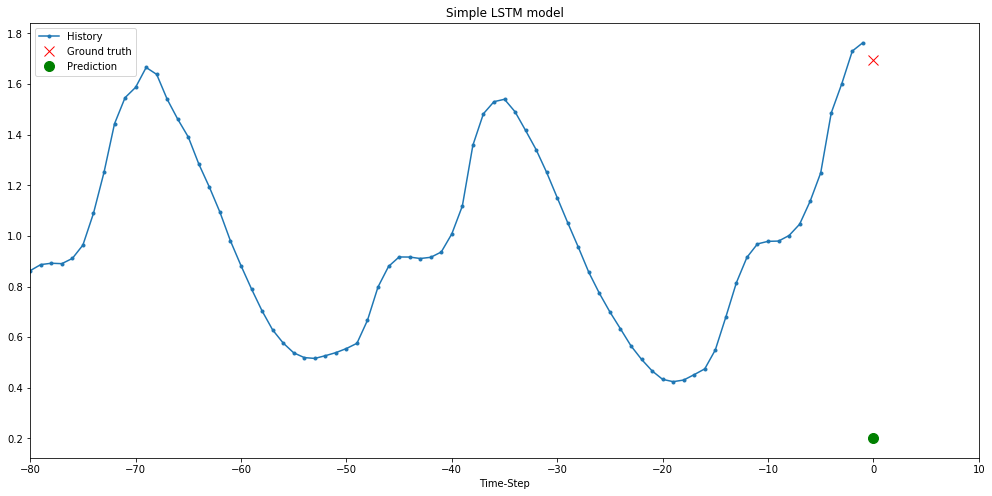

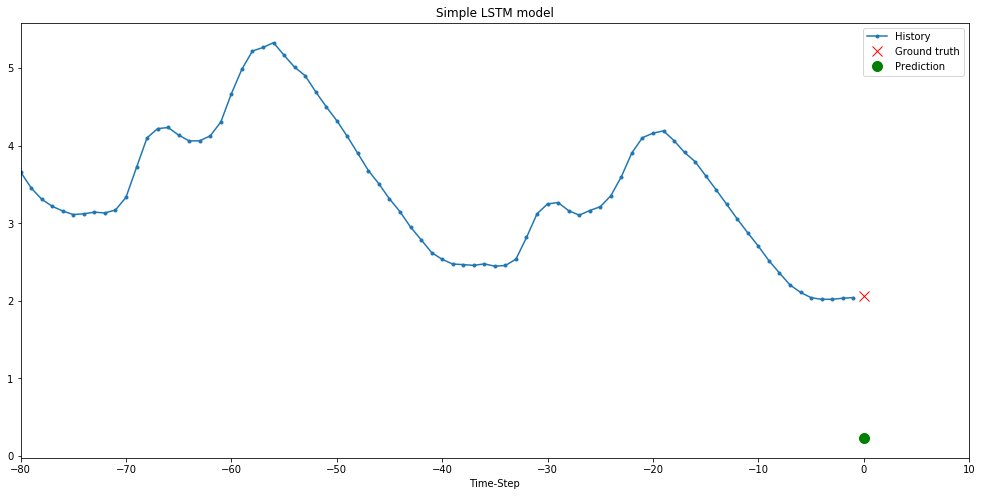

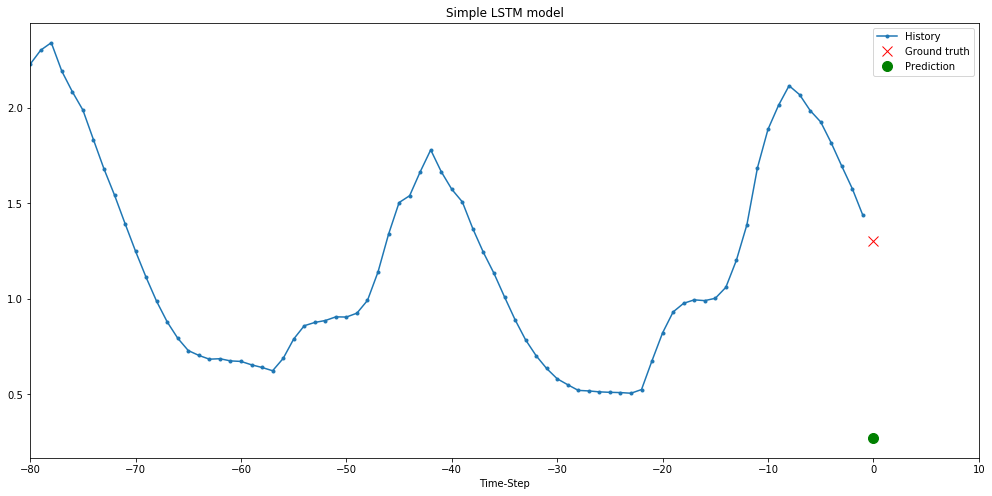

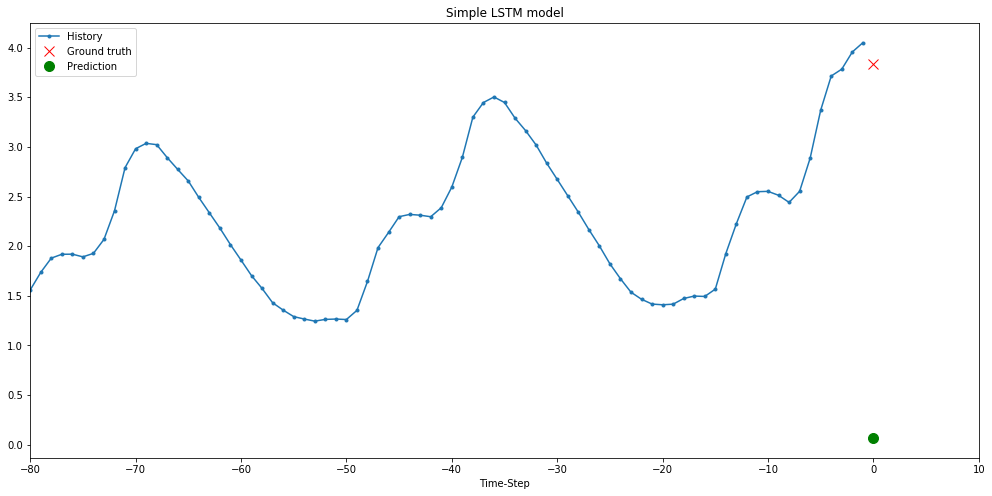

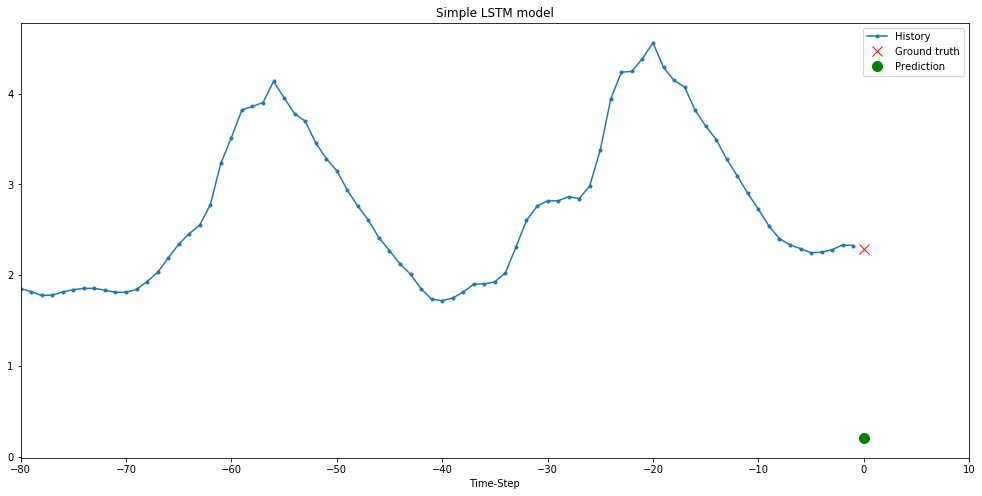

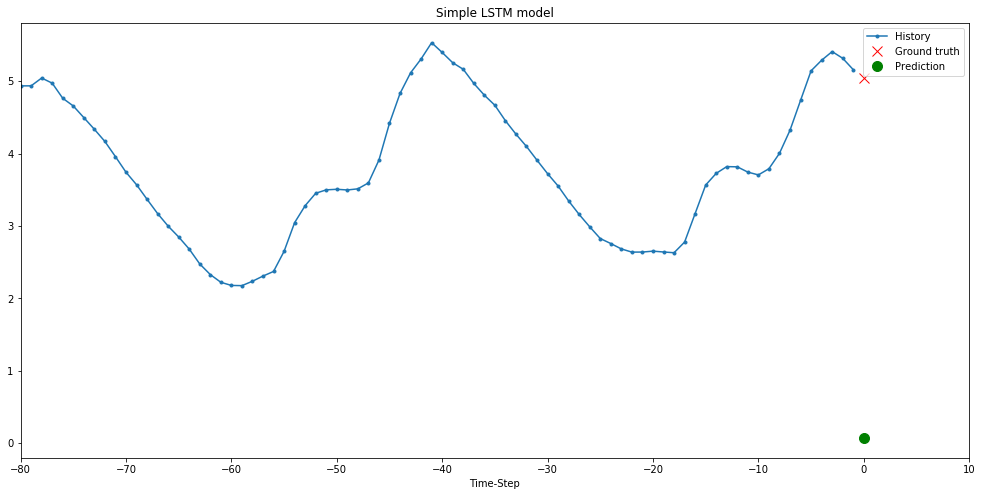

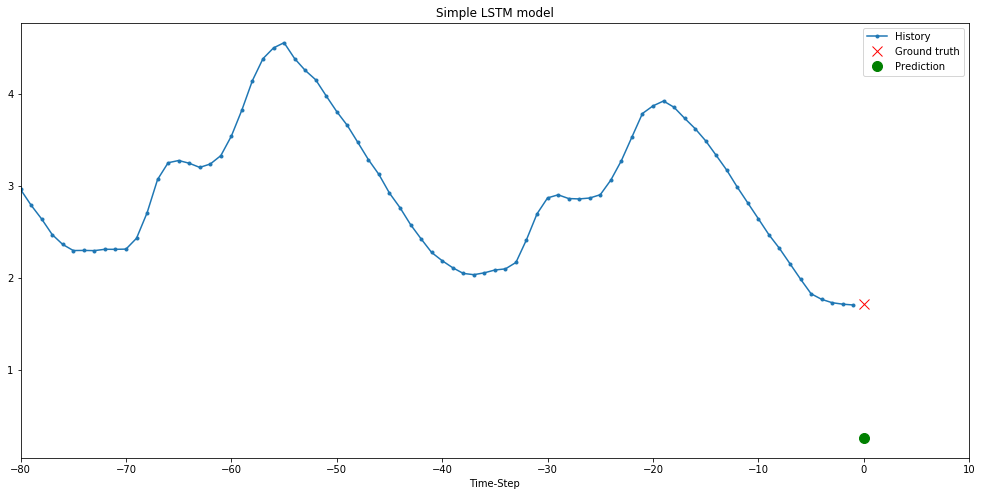

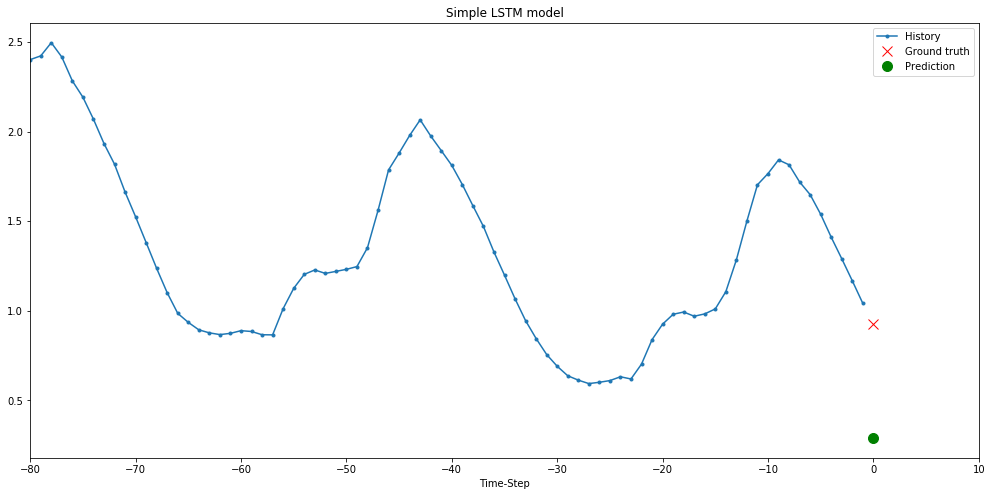

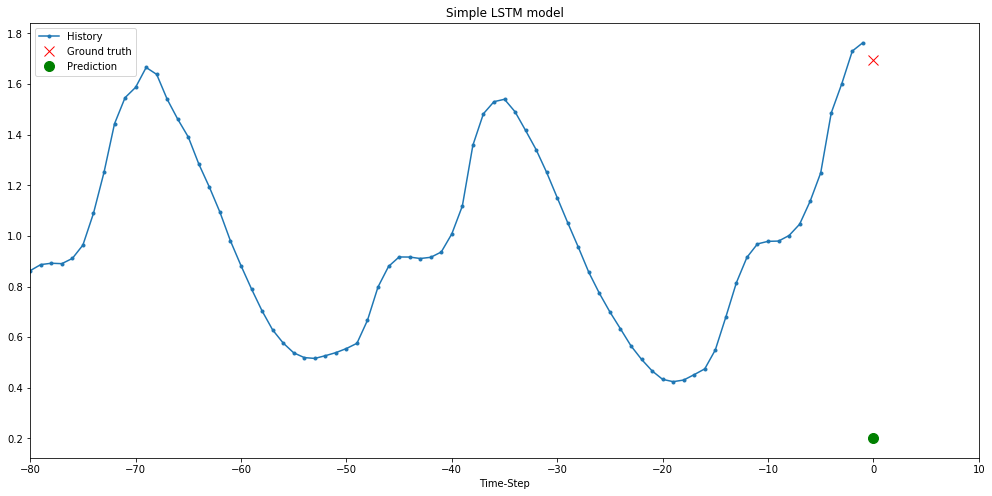

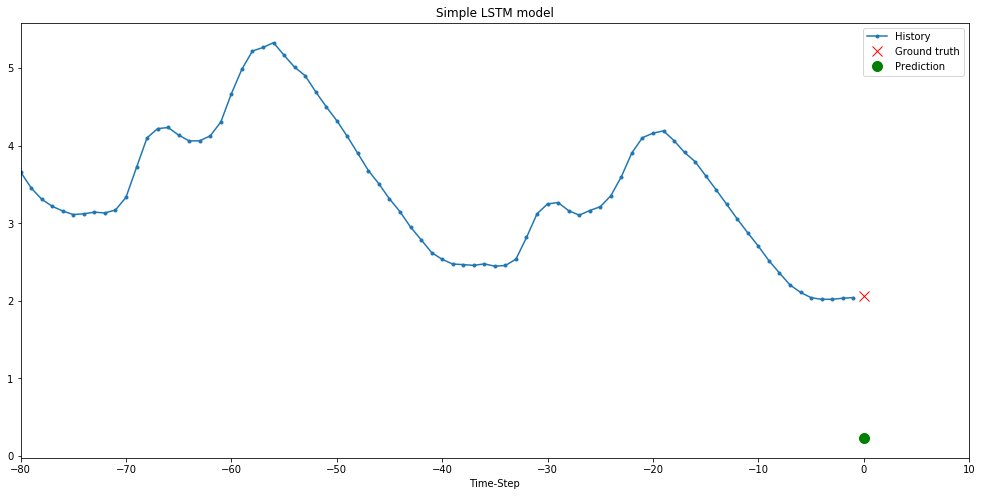

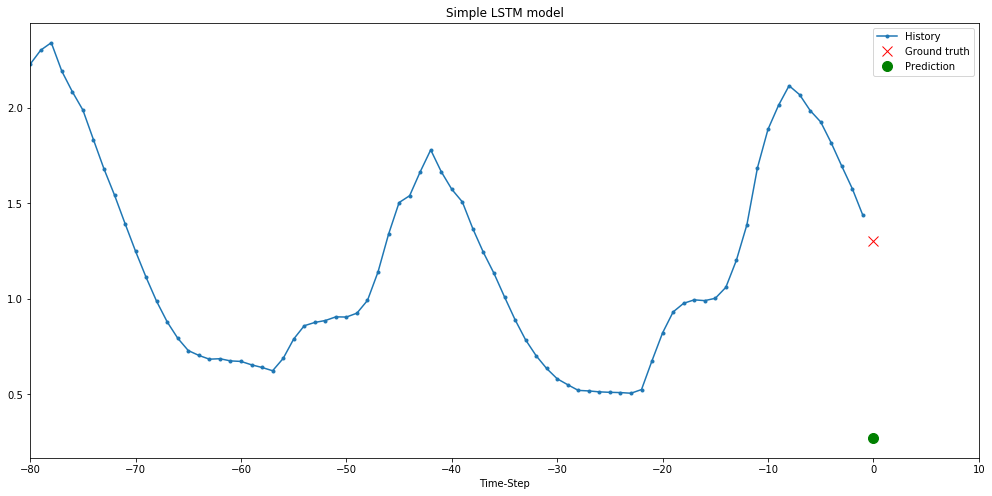

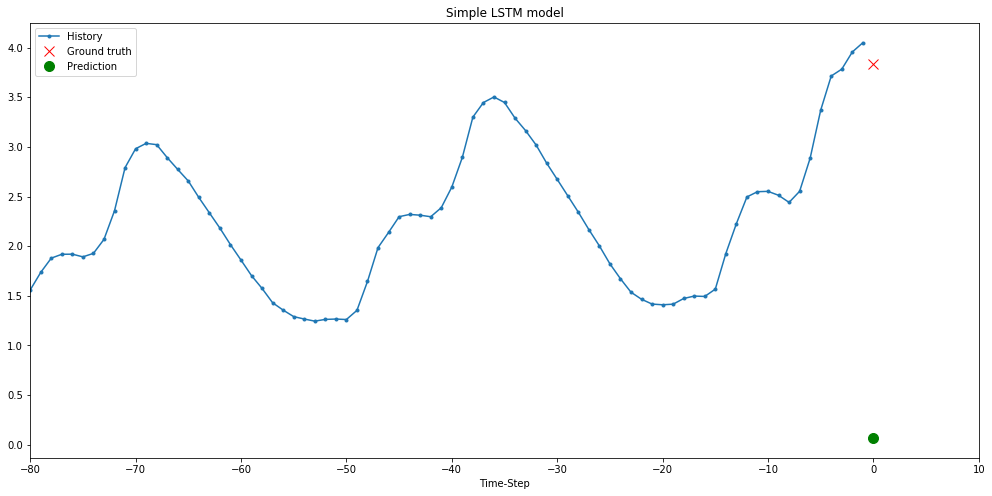

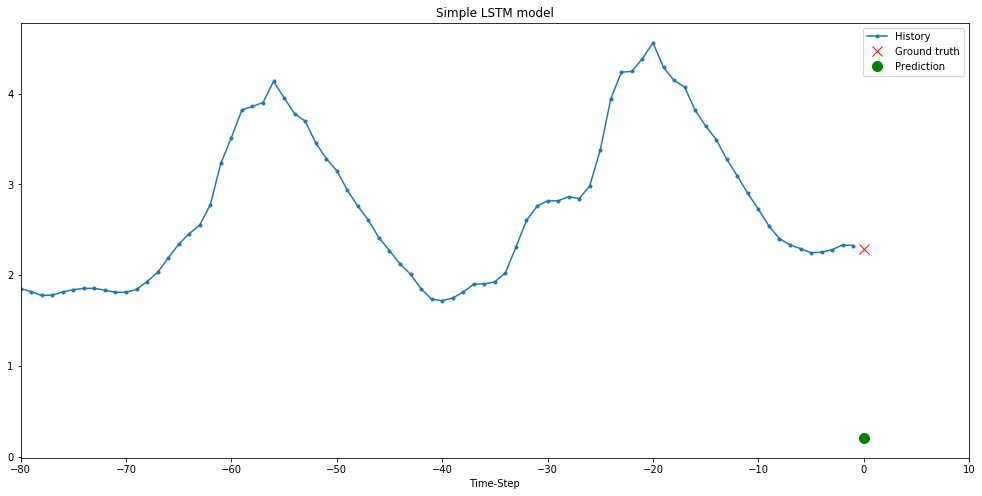

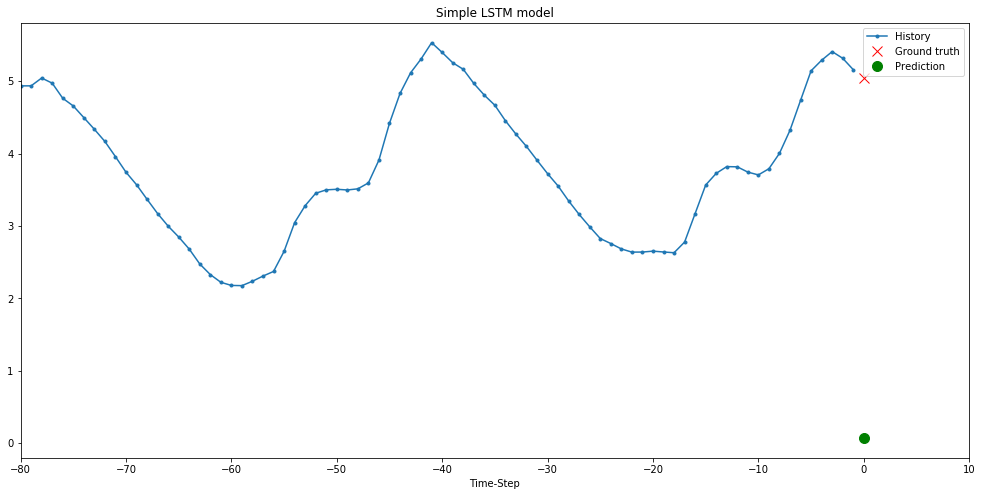

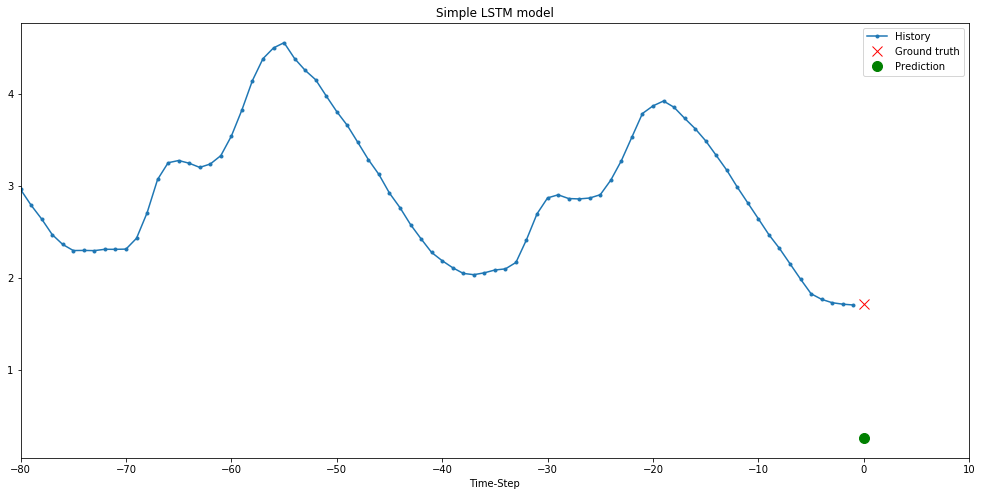

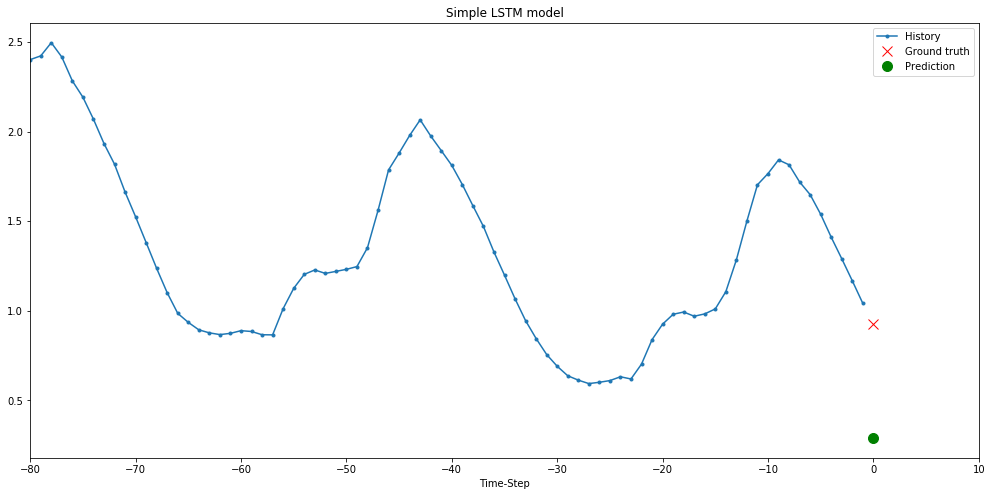

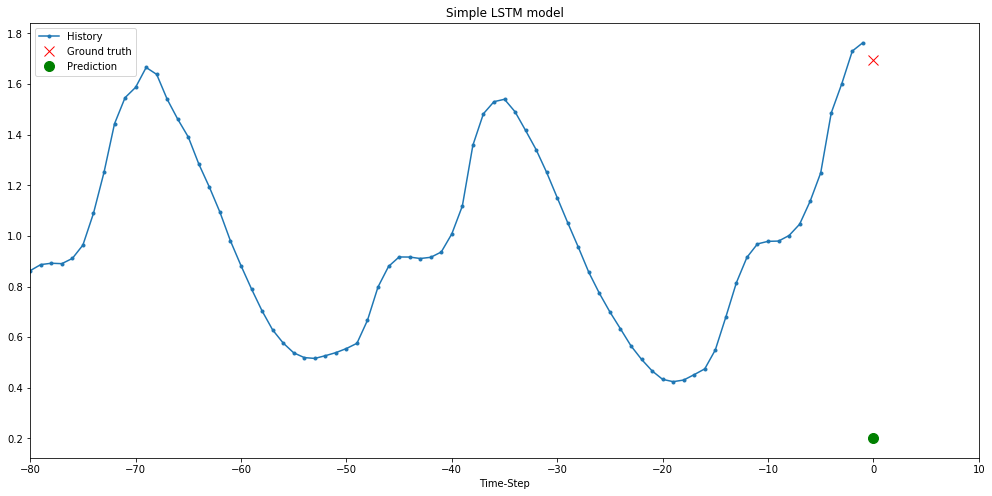

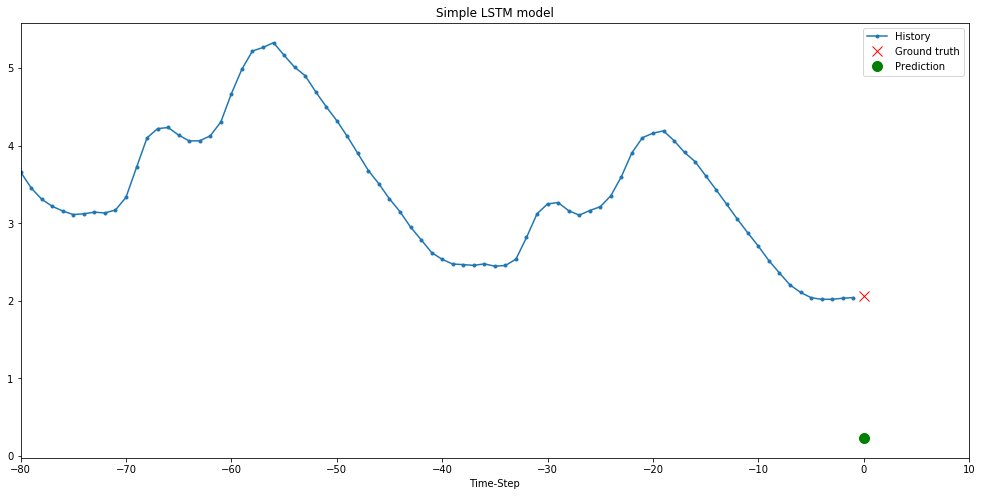

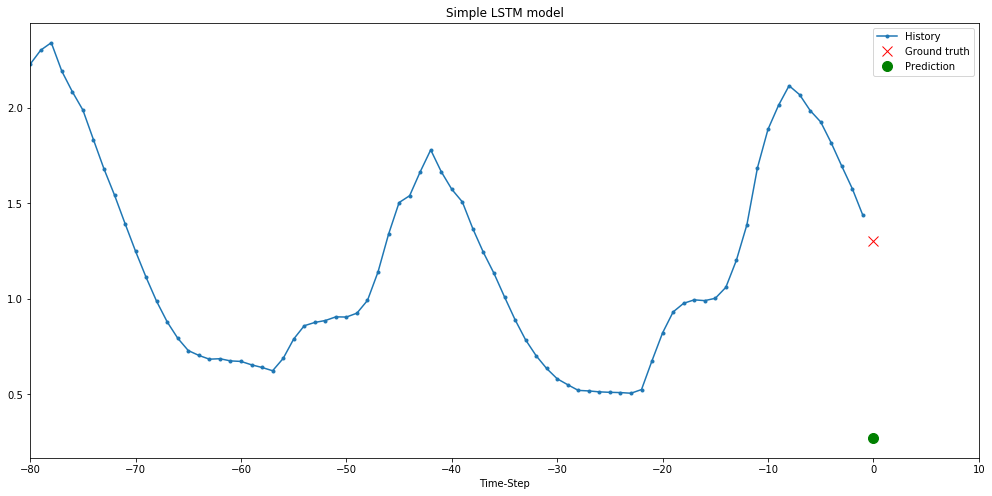

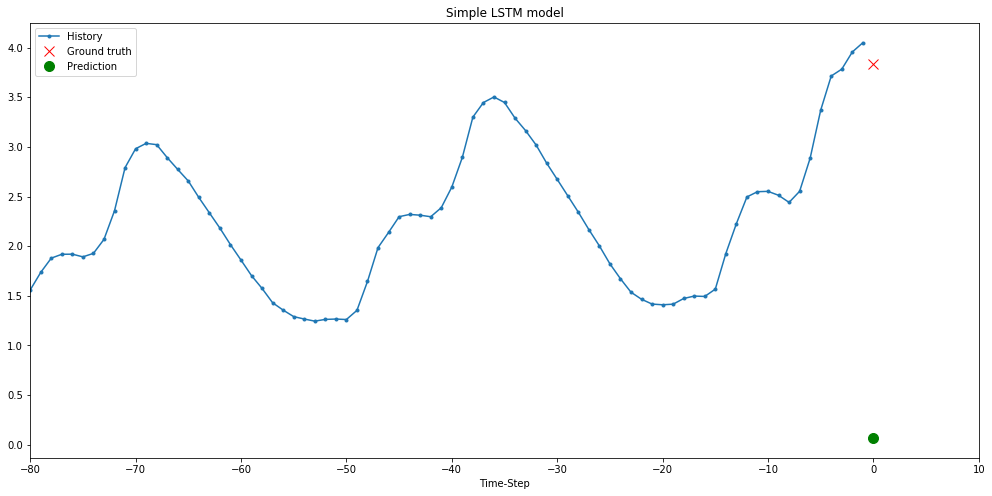

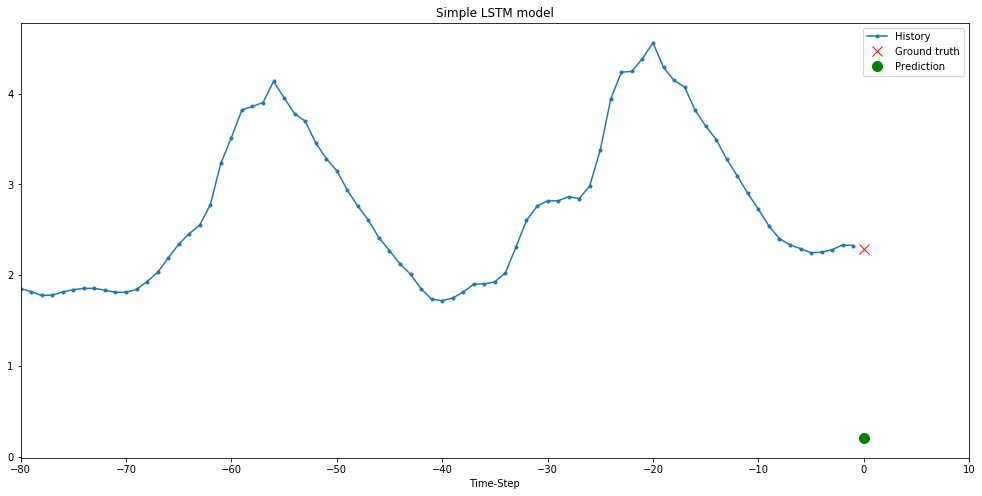

In [22]:
mpl.rcParams['figure.figsize'] = (17, 8)
mpl.rcParams['axes.grid'] = False
for x, y in val_univariate.take(100):
    plot = show_plot([x[future_target].numpy(), y[future_target].numpy(), simple_lstm_model.predict(x)[future_target]], future_target, 'Simple LSTM model')
    plot.show()